In [4]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import json
from tqdm import tqdm
import yaml

#import geopandas as gpd
import pandas as pd

import torch

import sys
sys.path.append('../')

import utils.basics as bsc 
import utils.plotting as pt
import utils.processing as proc
import utils.eval_pipe as eval

import utils.model_loader as md
import utils.data_loader as dt
import utils.config_loader as cf

%load_ext autoreload
%autoreload 2


## manual

In [4]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[0:7]  # Select the first 6 experiment names

global_config = md.global_config


In [ ]:
df_result = pd.DataFrame()
for exp_name in experiment_names:
    sites, cfg = cf.get_config(exp_name)
    global_config = md.global_config
    model_weights, logs, cfg = md.load_results(exp_name)
    preds_val, targets_val, preds_test, targets_test, maskval, masktest = [None] * 6
    preds_val, targets_val, preds_test, targets_test, maskval, masktest = md.load_np_stacks(exp_name)
    report = eval.ziptheresults(exp_name, model_weights, logs, cfg, preds_val, targets_val, preds_test, targets_test, maskval, masktest)
    df_result = eval.write_metrics_to_df(report, sites, global_config, df=df_result)
    print("====================================")
    print("EVAL REPORT FOR EXPERIMENT: ", exp_name)
    #eval.print_all_metrics(report, sites, cfg, above2m=True)
    #eval.plot_error_over_frequency(report, bins=80, title = f"{exp_name} - Error vs. GT Distribution")
    eval.printout_eval_report(report, sites, cfg)
    print("====================================")

    # Print the evaluation report
print(df_result.transpose().to_string())
# Save the transposed DataFrame to a CSV file with optional override
override = False
path = "../results/eval/tables/results_summary.csv"
os.makedirs(os.path.dirname(path), exist_ok=True)

if override:
    df_result.transpose().to_csv(path)
    print("Results saved to", path)
else:
    base, ext = os.path.splitext(path)
    suffix = 1
    new_path = f"{base}_{suffix}{ext}"
    while os.path.exists(new_path):
        suffix += 1
        new_path = f"{base}_{suffix}{ext}"
    df_result.transpose().to_csv(new_path)
    print("Results saved to", new_path)

EVAL REPORT FOR EXPERIMENT:  01_baseline
EVAL REPORT FOR EXPERIMENT:  02_pixel_composites
EVAL REPORT FOR EXPERIMENT:  03_seasonal_composites
EVAL REPORT FOR EXPERIMENT:  04_pixel_and_seasonal_comp
EVAL REPORT FOR EXPERIMENT:  05_support_fmask_dlt
EVAL REPORT FOR EXPERIMENT:  06_support_fmask_dlt_dem
EVAL REPORT FOR EXPERIMENT:  07_aux_task
                                    0                    1                       2                           3                     4                         5                  6
Experiment                01_baseline  02_pixel_composites  03_seasonal_composites  04_pixel_and_seasonal_comp  05_support_fmask_dlt  06_support_fmask_dlt_dem        07_aux_task
MAE [m] (Val)                    3.92                 4.14                    4.01                         3.7                  3.75                       3.7               3.81
MAE [m] (Test)                   4.17                 4.28                     4.0                        3.58             

## 250 again

In [282]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[0:7]  # Select the first 6 experiment names

df_result = pd.DataFrame()
for exp_name in experiment_names:
    sites, cfg = get_config(exp_name)
    global_config = md.global_config
    model_weights, logs, cfg = md.load_results(exp_name)
    preds_val, targets_val, preds_test, targets_test, maskval, masktest = [None] * 6
    preds_val, targets_val, preds_test, targets_test, maskval, masktest = md.load_np_stacks(exp_name)
    report = eval.ziptheresults(exp_name, model_weights, logs, cfg, preds_val, targets_val, preds_test, targets_test, maskval, masktest)
    df_result = eval.write_metrics_to_df(report, sites, global_config, df=df_result)
    print("====================================")
    print("EVAL REPORT FOR EXPERIMENT: ", exp_name)
    #eval.print_all_metrics(report, sites, cfg, above2m=True)
    #eval.plot_error_over_frequency(report, bins=80, title = f"{exp_name} - Error vs. GT Distribution")
    eval.printout_eval_report(report, sites, cfg)
    #print("====================================")

    # Print the evaluation report
print(df_result.transpose().to_string())
# Save the transposed DataFrame to a CSV file with optional override
override = False
path = "../results/eval/tables/results_summary.csv"
os.makedirs(os.path.dirname(path), exist_ok=True)

if override:
    df_result.transpose().to_csv(path)
    print("Results saved to", path)
else:
    base, ext = os.path.splitext(path)
    suffix = 1
    new_path = f"{base}_{suffix}{ext}"
    while os.path.exists(new_path):
        suffix += 1
        new_path = f"{base}_{suffix}{ext}"
    df_result.transpose().to_csv(new_path)
    print("Results saved to", new_path)

EVAL REPORT FOR EXPERIMENT:  01_baseline
EVAL REPORT FOR EXPERIMENT:  02_pixel_composites
EVAL REPORT FOR EXPERIMENT:  03_seasonal_composites
EVAL REPORT FOR EXPERIMENT:  04_pixel_and_seasonal_comp
EVAL REPORT FOR EXPERIMENT:  05_support_fmask_dlt
EVAL REPORT FOR EXPERIMENT:  06_support_fmask_dlt_dem
EVAL REPORT FOR EXPERIMENT:  07_aux_task
                                         0                    1                       2                           3                     4                         5                  6
Experiment                     01_baseline  02_pixel_composites  03_seasonal_composites  04_pixel_and_seasonal_comp  05_support_fmask_dlt  06_support_fmask_dlt_dem        07_aux_task
MAE [m] (Val)                          4.0                 4.13                    3.75                        3.82                  3.81                      3.69               3.73
MAE [m] (Test)                        4.23                 4.27                    3.79                     

## most recents

In [86]:
preds_val.shape

(181, 3, 32, 32)

In [38]:
#run_ids = ["251009_2", "251009_3", "251009_4", "251009_5", "251009_6", "251009_7"]
run_ids = ["251009_500_"+str(i) for i in range(10)]
run_ids = ["251009_600_"+str(i) for i in range(5)]
run_ids = ["251017_all_Q_"+str(i) for i in range(3)]
run_ids = ["251021_N_"+str(i) for i in range(2)]

run_ids = ["251023_MIN_"+str(i) for i in range(2)]

run_ids = ["251024_FINAL_" + str(i) for i in range(5)]
run_ids = ["251101_HUBER_" + str(i) for i in range(5)]
run_ids = ["251102__" + str(i) for i in range(5)]
#run_ids = ["251101_HUBER_1"]
#run_ids = ["251025_FINAL_" + str(i) for i in range(5)]
#run_ids = ["251025_FINAL_0"]


In [78]:
run_ids #= run_ids[1:6]

['251102__0', '251102__1', '251102__2', '251102__3', '251102__4']

In [ ]:
# SELECT EXPERIMENTAL CONFIG
for run_id in tqdm(run_ids):
    with open('../configs/experiments.yaml', 'r') as f:
        experiments = yaml.safe_load(f)
        # experiment_names = list(experiments.keys())
        #run_id = "251009_4" #"250929_02" #"250930_1"
        exp_dir = os.path.join("..", "results", run_id, "train")
        experiment_names = sorted(
            [name for name in os.listdir(exp_dir) if os.path.isdir(os.path.join(exp_dir, name))]
        )
        #experiment_names = experiment_names[6:7]  # Select the first 7 experiment names
        print("Available experiments:", experiment_names)

    df_result = pd.DataFrame()
    for exp_name in experiment_names:
        sites, cfg = cf.get_config(exp_name)
        #global_config = md.global_config
        model_weights, logs, cfg = md.load_results(exp_name, run_id)
        preds_val, targets_val, preds_test, targets_test, maskval, masktest, rgb_test = [None] * 7
        preds_val, targets_val, preds_test, targets_test, maskval, masktest, rgb_test = md.load_np_stacks(exp_name, run_id)
        report = eval.ziptheresults(exp_name, model_weights, logs, cfg, preds_val, targets_val, preds_test, targets_test, maskval, masktest, rgb_test)
        df_result = eval.write_metrics_to_df(report, sites, cfg, df=df_result)
        # print("===========================")
        # print("EVAL REPORT FOR EXPERIMENT: ", exp_name)
        #eval.print_all_metrics(report, sites, cfg, above2m=True)
        #eval.plot_error_over_frequency(report, bins=80, title = f"{exp_name} - Error vs. GT Distribution")
        eval.printout_eval_report(report, sites, cfg, run_id)
        #print("====================================")

        # Print the evaluation report
    #print(df_result.transpose().to_string())
    eval.save_df_result_to_csv(df_result, run_id, override=True)


  0%|          | 0/5 [00:00<?, ?it/s]

Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 20%|██        | 1/5 [00:03<00:13,  3.38s/it]

Results saved to ../results/251102__0/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 40%|████      | 2/5 [00:06<00:09,  3.07s/it]

Results saved to ../results/251102__1/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 60%|██████    | 3/5 [00:09<00:06,  3.18s/it]

Results saved to ../results/251102__2/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


 80%|████████  | 4/5 [00:12<00:03,  3.07s/it]

Results saved to ../results/251102__3/metrics/results_summary.csv
Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


100%|██████████| 5/5 [00:15<00:00,  3.08s/it]

Results saved to ../results/251102__4/metrics/results_summary.csv


In [94]:
test = preds_val[:,1:,:,:]
test[:,1,:,:].flatten().mean()

np.float32(1.0849096)

In [95]:
eval.get_aux_metrics(report)

Unique classes in GT Channel 2: [0. 1. 2.]
Length before masking: 175104
Length after masking: 171016
Unique classes in Pred Channel 2: [0. 1. 2.]
Length before masking: 175104
Length after masking: 171016
Auxiliary Metrics:
	F1 Score Channel 1 (Binary): 	0.9814
 	F1 Score Channel 2 (Micro): 	0.9486
----------------------------------------------


(0.9814296976598454, 0.9485662160265707)

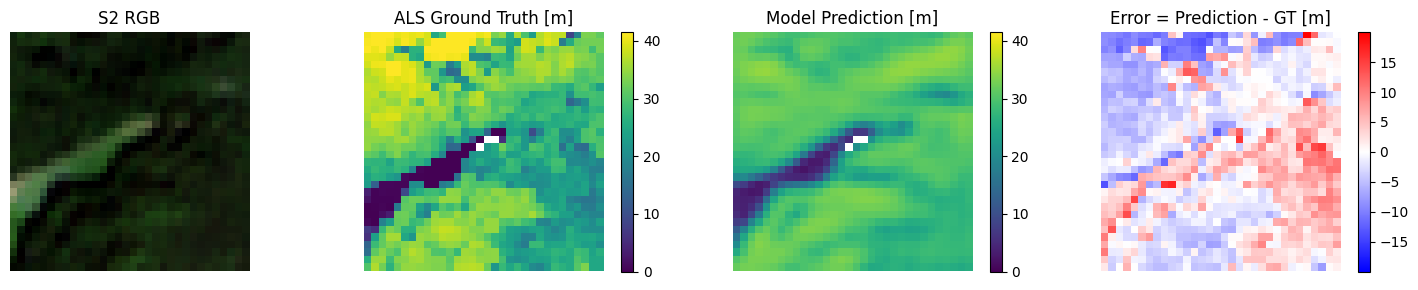

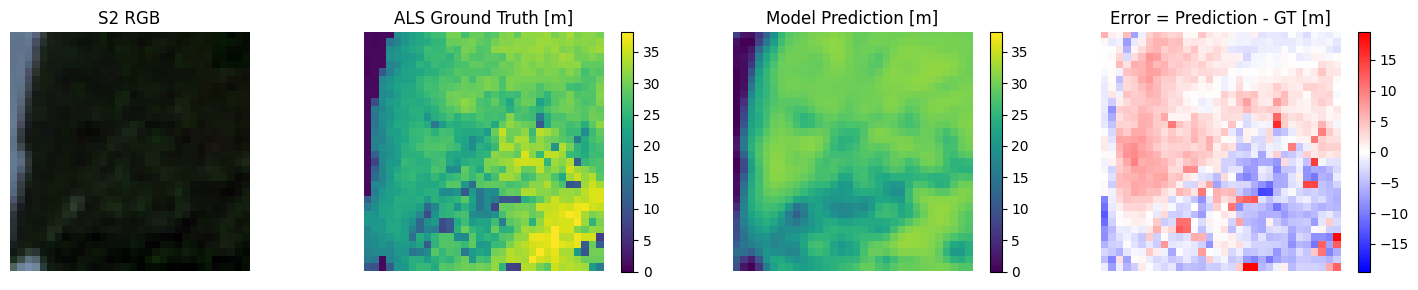

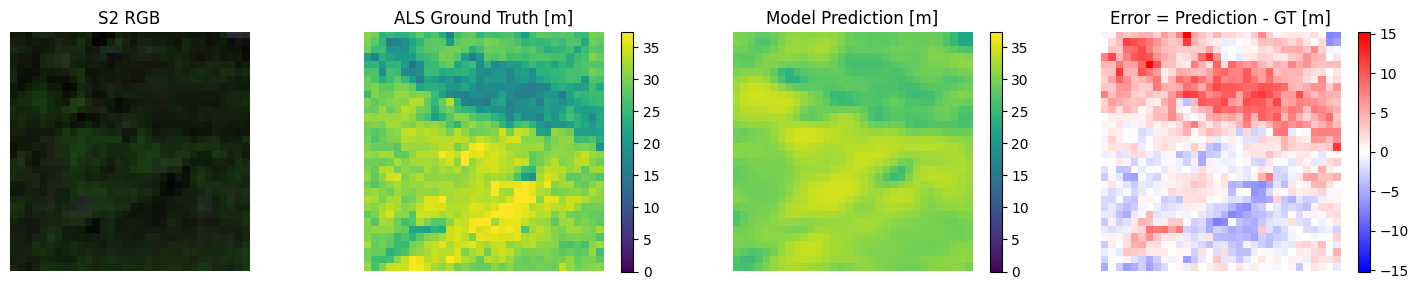

In [263]:
eval.plot_real_pred_delta(report, num_samples=3)

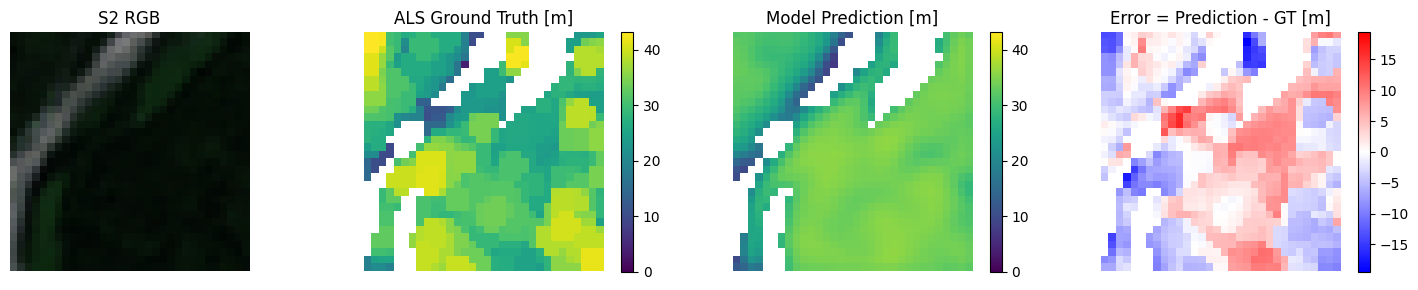

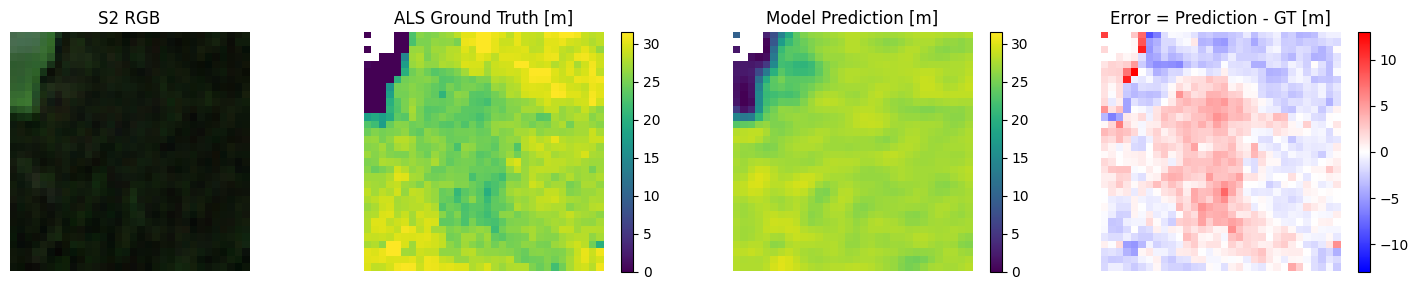

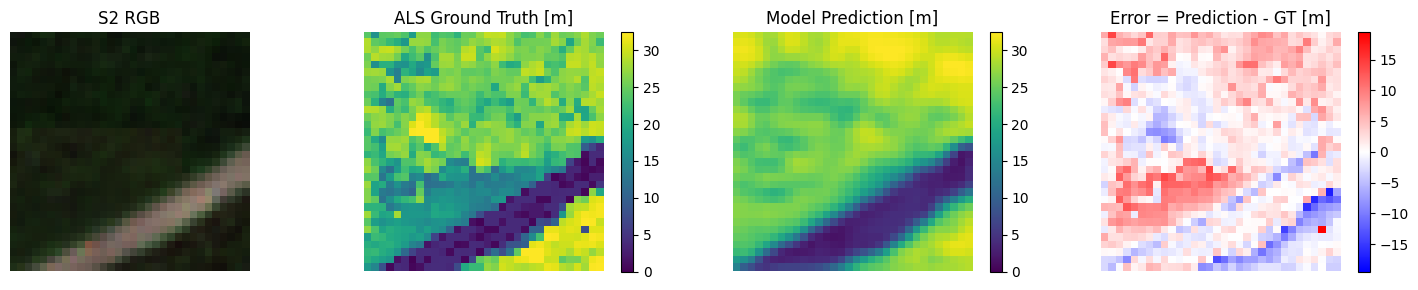

In [23]:
eval.plot_real_pred_delta(report, num_samples=3)

## plot metrics

In [ ]:
df_big = eval.read_multiple_csv_to_df(run_ids)


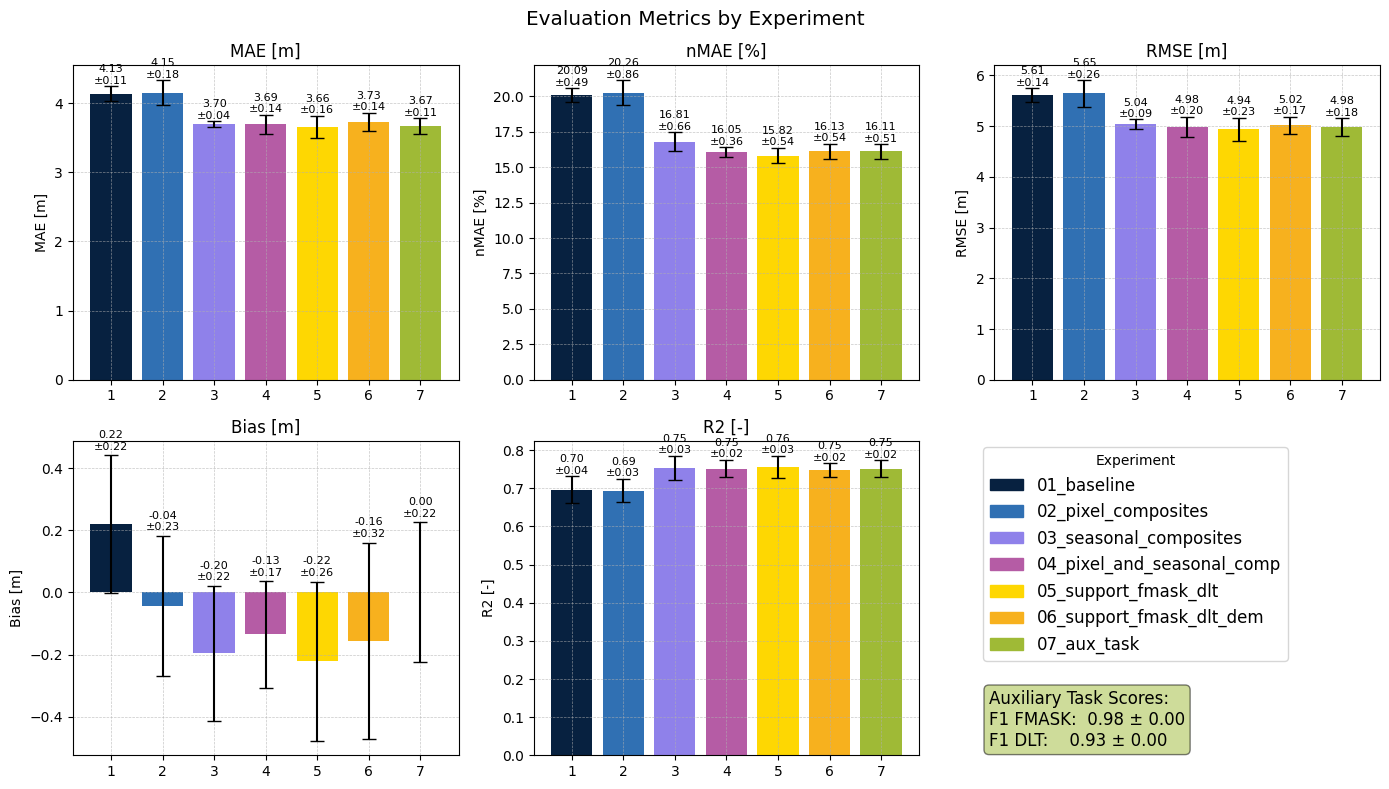

In [42]:
# 500 epochs, 5 iterations each; "final" for aux; huber = 3.5
fig, stats = eval.plot_experiment_metrics_multiple_runs(df_result=df_big,printout=False)

Including auxiliary task F1 scores in the plot.


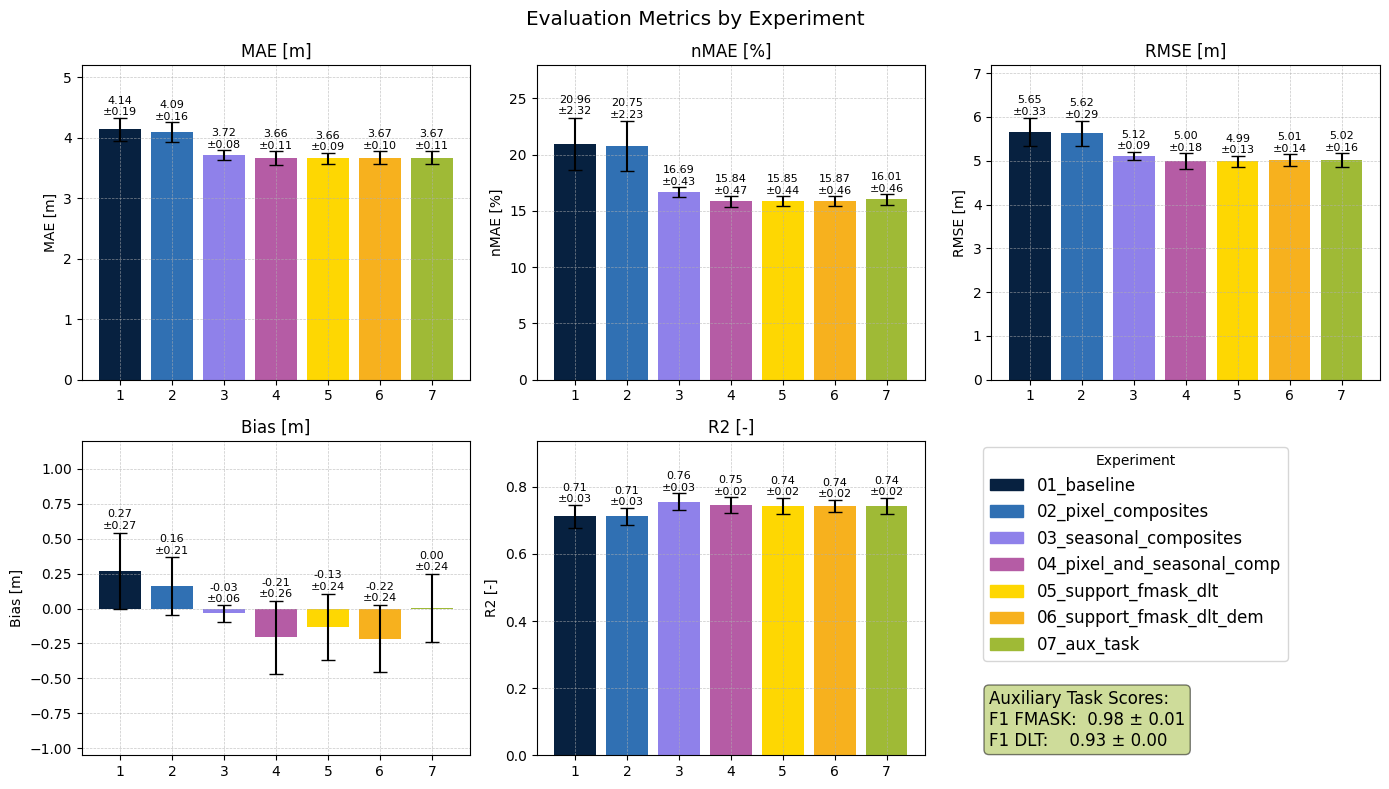

In [248]:
# 500 epochs, 5 iterations each; "final" for aux
fig, stats = eval.plot_experiment_metrics_multiple_runs(df_result=df_big,printout=False)

## sitewise metrics

In [ ]:
from sklearn.metrics import f1_score
dfs = pd.DataFrame()

for run_id in run_ids:
    for exp_name in experiment_names:
        sitecodes = np.load(f"../results/{run_id}/train/{exp_name}/test_site_indices.npz")["site_indices_test"]
        preds_val, targets_val, preds_test, targets_test, maskval, masktest, rgb_test = [None] * 7
        preds_val, targets_val, preds_test, targets_test, maskval, masktest, rgb_test = md.load_np_stacks(exp_name, run_id)

        # Compute metrics per site
        for site_id in np.unique(sitecodes):
            site_mask = sitecodes == site_id
            preds_site = preds_test[site_mask, 0, :, :].reshape(-1)
            targets_site = targets_test[site_mask, 0, :, :].reshape(-1)
            mask_site = masktest[site_mask, 0, :, :].reshape(-1).astype(bool)


            # Check if auxiliary task channels exist
            if preds_test.shape[1] > 1 and targets_test.shape[1] > 1:
                # Channel 1: F1 score (binary classification)
                fmask_gt_ch1 = targets_test[site_mask, 1, :, :].flatten()
                #fmask_gt_ch1 = fmask_gt_ch1[mask_site]
                fmask_pred_ch1 = (preds_test[site_mask, 1, :, :].flatten() > 0.5).astype(np.uint8)
                #fmask_pred_ch1 = fmask_pred_ch1[mask_site]
                f1_ch1 = f1_score(fmask_gt_ch1, fmask_pred_ch1, average='binary')

                # Channel 2: Multi-class classification (0, 1, 2)
                fmask_gt_ch2 = targets_test[site_mask, 2, :, :].flatten()
                #fmask_gt_ch2 = fmask_gt_ch2[mask_site]
                fmask_pred_ch2 = preds_test[site_mask, 2, :, :].flatten()
                #fmask_pred_ch2 = fmask_pred_ch2[mask_site]
                f1_micro = f1_score(fmask_gt_ch2, fmask_pred_ch2, average='micro')
            else:
                f1_ch1 = np.nan
                f1_micro = np.nan
            # Keep only unmasked values
            valid_idx = mask_site
            preds_valid = preds_site[valid_idx]
            targets_valid = targets_site[valid_idx]
            
            # Compute metrics
            mae, nmae, rmse, bias, r2 = eval.get_metrics(preds_valid, targets_valid, verbose=False)
            
            # Add to dataframe
            df_tmp = pd.DataFrame({
                "experiment": [exp_name],
                "run_id": [run_id],
                "site_id": [site_id],
                "MAE [m] (Test)": [mae],
                "nMAE [%] (Test)": [nmae],
                "RMSE [m] (Test)": [rmse],
                "Bias [m] (Test)": [bias],
                "R2 [-] (Test)": [r2],
                "F1 FMASK (Test)": [f1_ch1],
                "F1 DLT (Test)": [f1_micro],
                #"seed": [cfg['seed']]
            })
                # Select metrics columns
            metrics = [
                "MAE [m] (Test)",
                "nMAE [%] (Test)",
                "RMSE [m] (Test)", 
                "Bias [m] (Test)",
                "R2 [-] (Test)",
                "F1 FMASK (Test)",
                "F1 DLT (Test)"
            ]   
            
            dfs = pd.concat([dfs, df_tmp], ignore_index=True)



In [98]:
dfs["F1 DLT (Test)"].mean()

np.float64(0.9379709767961831)

In [75]:
# melt the df, we want to group by experiment and site_id, aggregating mean and std
dfmelt = dfs.melt(id_vars=["experiment", "site_id"], value_vars=metrics, var_name="metric", value_name="value")
dfmelt = dfmelt.groupby(["experiment", "site_id", "metric"])["value"].agg(["mean", "std"]).reset_index()
dfmelt.columns = ["experiment", "site_id", "metric", "mean", "std"]

path = "../results/all_in/final/metrics/sitewise_metrics_summary.csv"
os.makedirs(os.path.dirname(path), exist_ok=True)
dfmelt.to_csv(path)
print("Site-wise metrics summary saved to", path)

Site-wise metrics summary saved to ../results/all_in/final/metrics/sitewise_metrics_summary.csv


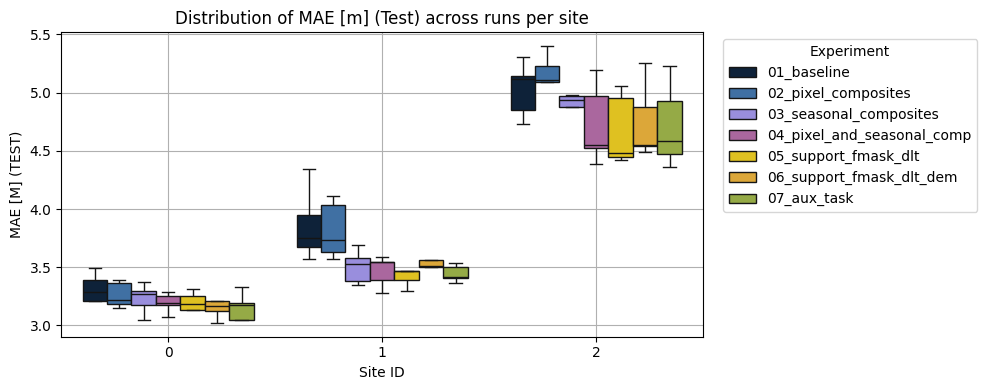

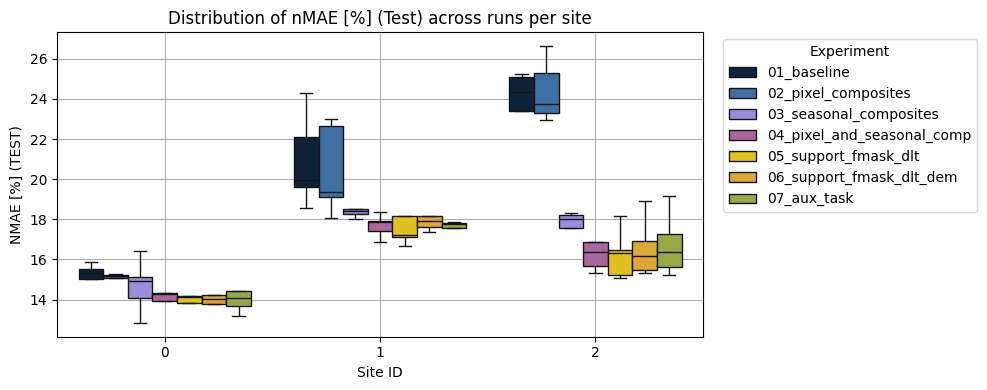

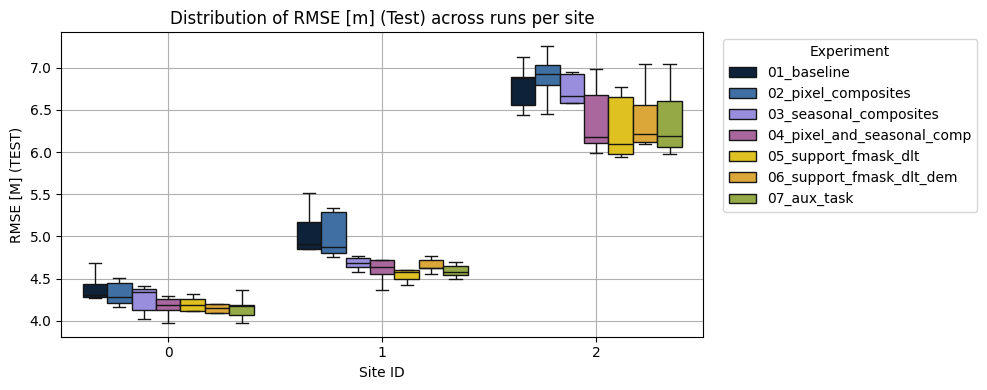

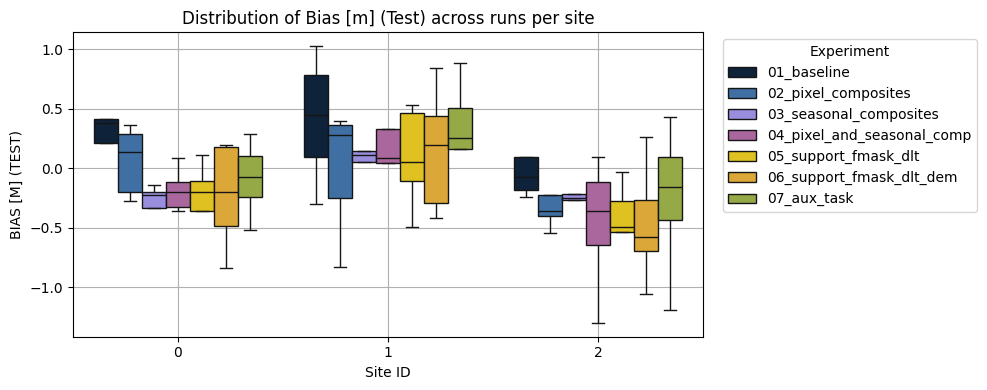

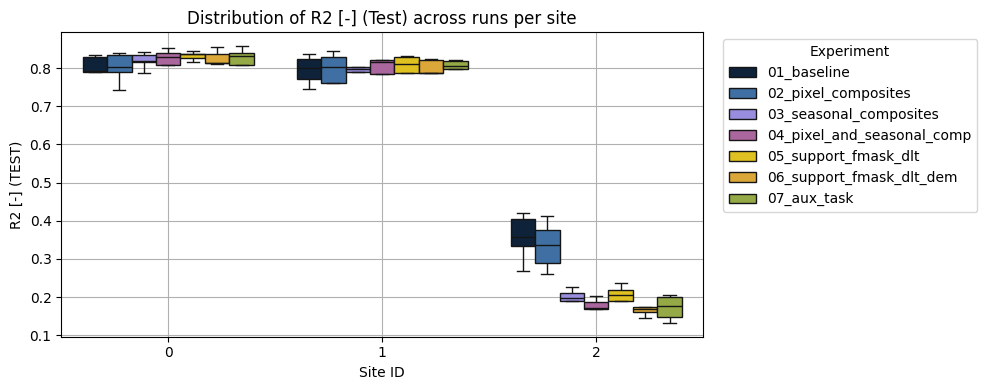

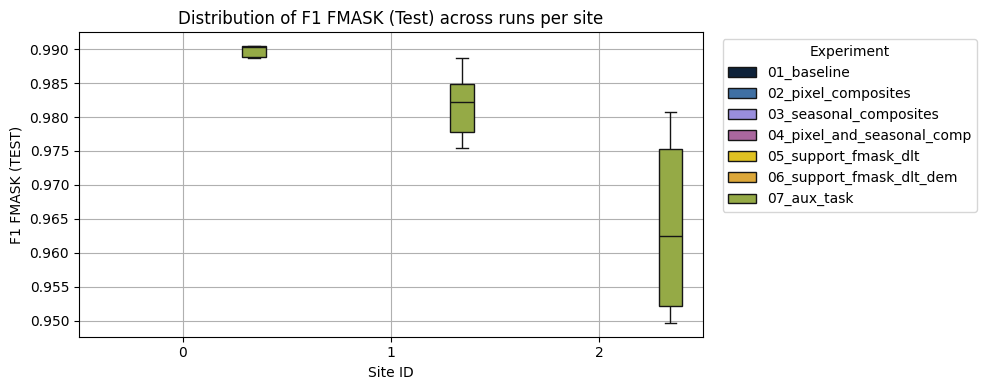

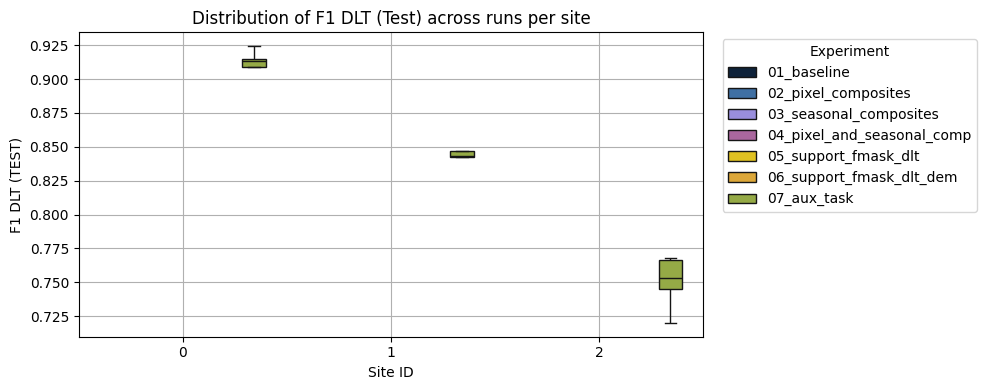

In [ ]:
import seaborn as sns
# now for each esperiment and site, plot boxplots of mae, nmae, rmse, bias, r2 across runs
metrics = [
    "MAE [m] (Test)",
    "nMAE [%] (Test)",
    "RMSE [m] (Test)", 
    "Bias [m] (Test)",
    "R2 [-] (Test)",
    "F1 FMASK (Test)",
    "F1 DLT (Test)"
]  
# Custom color palette
palette = [0x072140, 0x3070B3, 0x8F81EA, 0xB55CA5, 0xFED702, 0xF7B11E, 0x9FBA36]
palette = [f'#{color:06X}' for color in palette]
exp_names = dfs['experiment'].unique()

exp_palette = {exp: palette[i % len(palette)] for i, exp in enumerate(exp_names)}
for metric in metrics:
    plt.figure(figsize=(10, 4))
    ax = plt.gca()
    #sns.barplot(data=dfs, x="site_id", y=metric, hue="experiment", ax=ax, errorbar="sd", palette=exp_palette)
    sns.boxplot(data=dfs, x="site_id", y=metric, hue="experiment", ax=ax, palette=exp_palette, showfliers=False)
    plt.title(f"Distribution of {metric} across runs per site")
    plt.xlabel("Site ID")
    plt.ylabel(metric.upper())
    plt.legend(title="Experiment", bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.grid()
    plt.show()

In [48]:
targets_test.shape

(171, 3, 32, 32)

### migration of results

In [ ]:
# migration all in 
#target_run_ids = ["251026_FINAL_" + str(i) for i in range(5)]
target_run_ids = ["251024_FINAL_" + str(i) for i in range(5)]
origin = ["251025_FINAL_" + str(i) for i in range(5)]

for t_run_id, o_run_id in zip(target_run_ids, origin):
    path_origin = os.path.join("../results", o_run_id, "train", "07_aux_task")
    path_target = os.path.join("../results", t_run_id, "train", "07_aux_task")
    os.makedirs(path_target, exist_ok=True)
    for file_name in os.listdir(path_origin):
        full_file_name = os.path.join(path_origin, file_name)
        if os.path.isfile(full_file_name):
            subprocess.run(["cp", full_file_name, path_target])
            print(f"Copied {full_file_name} to {path_target}")

In [249]:
# migration all in 
#target_run_ids = ["251026_FINAL_" + str(i) for i in range(5)]

target_run_id_base = "251021_GEN_"
origin_run_id_base = "251025_GEN_"
repetitions = 5
combos = ["110","101","011"] #1 is training data, 0 test. logic is LSB: 001 -> SITE1 is training data. 
target_run_ids = []
origin_run_ids = []

for i in range(repetitions): # Run 10 experiments with different seeds
    for combo in combos:
        #run_id = md.generate_run_id()
        run_id = target_run_id_base + f"_{combo}_{i}"
        target_run_ids.append(run_id)

        origin_run_id = origin_run_id_base + f"_{combo}_{i}"
        origin_run_ids.append(origin_run_id)
origin = origin_run_ids

for t_run_id, o_run_id in zip(target_run_ids, origin):
    path_origin = os.path.join("../results", o_run_id, "train", "07_aux_task")
    path_target = os.path.join("../results", t_run_id, "train", "07_aux_task")
    os.makedirs(path_target, exist_ok=True)
    for file_name in os.listdir(path_origin):
        full_file_name = os.path.join(path_origin, file_name)
        if os.path.isfile(full_file_name):
            subprocess.run(["cp", full_file_name, path_target])
            #print(f"Copied {full_file_name} to {path_target}")
print("Done copying auxiliary task files.")


Done copying auxiliary task files.


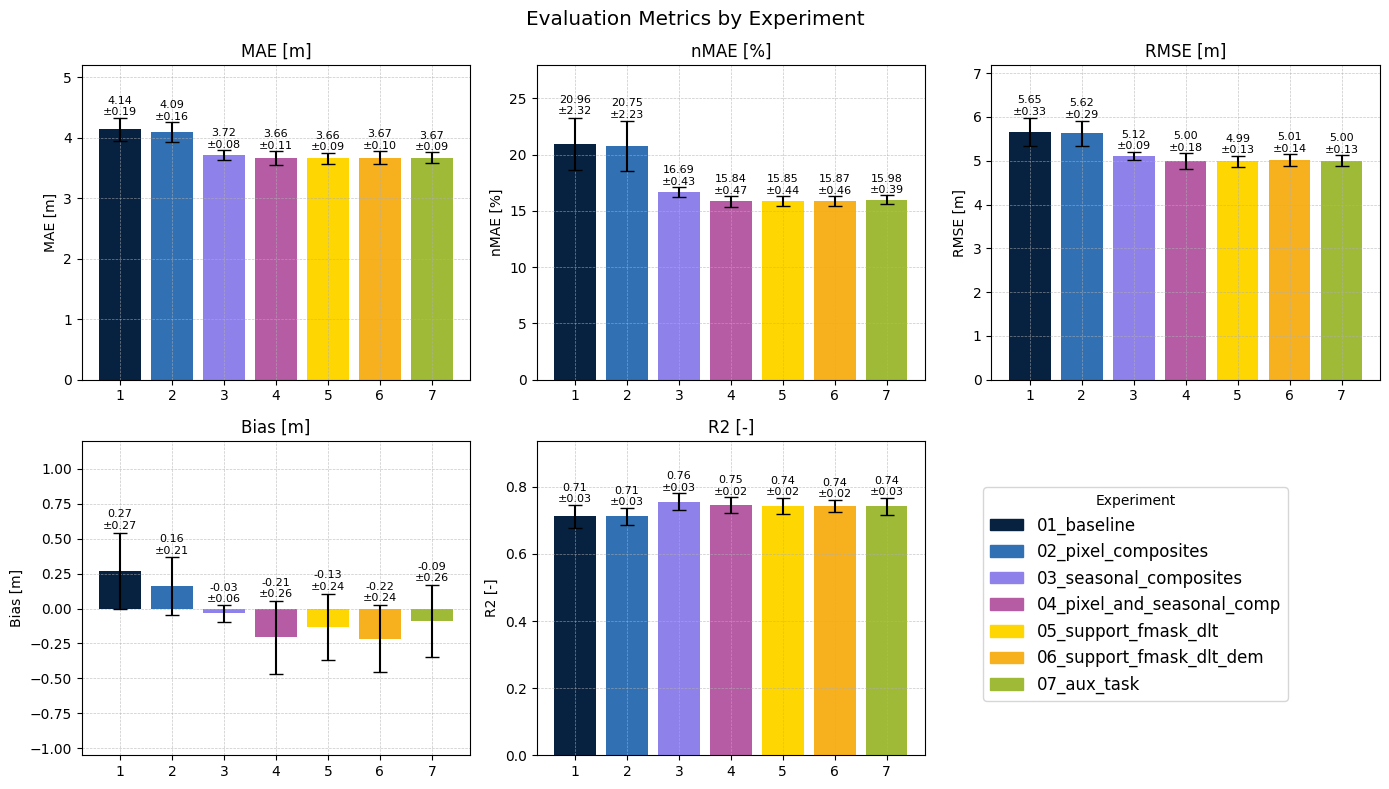

In [22]:
# 500 epochs, 5 iterations each; "final"
fig, stats = eval.plot_experiment_metrics_multiple_runs(df_result=df_big,printout=False)

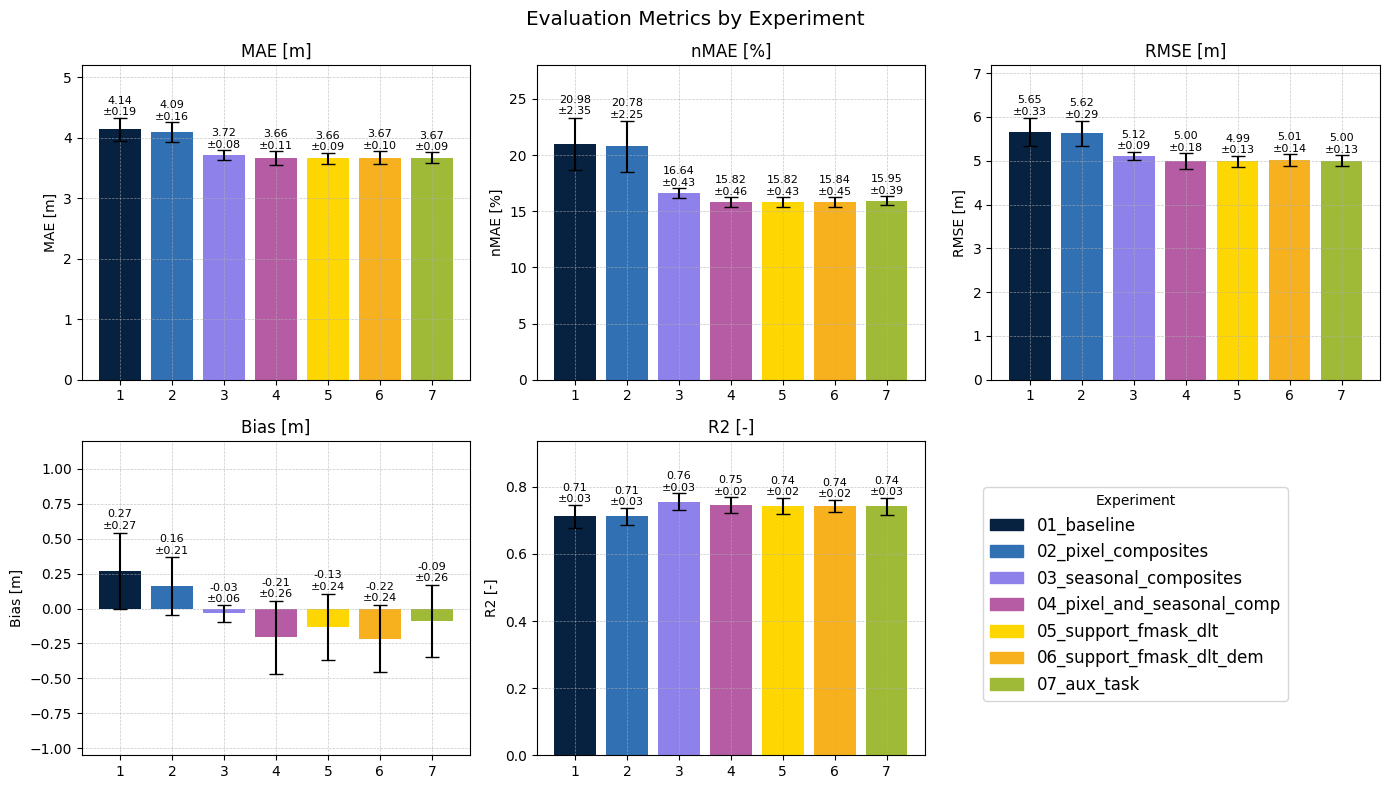

In [ ]:
# 500 epochs, 5 iterations each; "final"
fig, stats = eval.plot_experiment_metrics_multiple_runs(df_result=df_big,printout=False)

In [32]:
stats

Experiment   mean       std
0                 01_baseline  0.715  0.007071
1         02_pixel_composites  0.720  0.000000
2      03_seasonal_composites  0.765  0.021213
3  04_pixel_and_seasonal_comp  0.745  0.021213
4        05_support_fmask_dlt  0.745  0.021213
5    06_support_fmask_dlt_dem  0.755  0.021213
6                 07_aux_task  0.750  0.014142

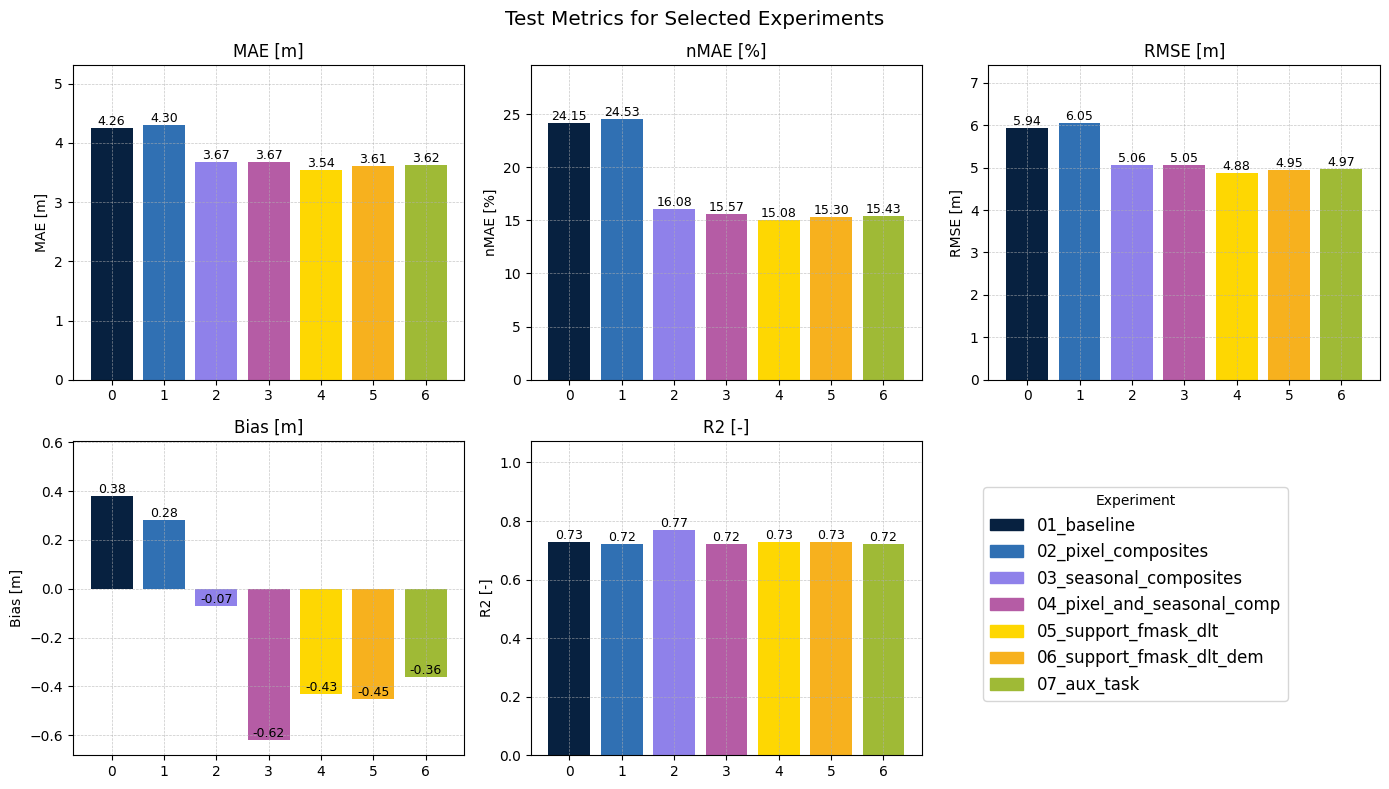

In [17]:
eval.plot_experiment_metrics_test_only(df_result, title="Test Metrics for Selected Experiments", printout=True)

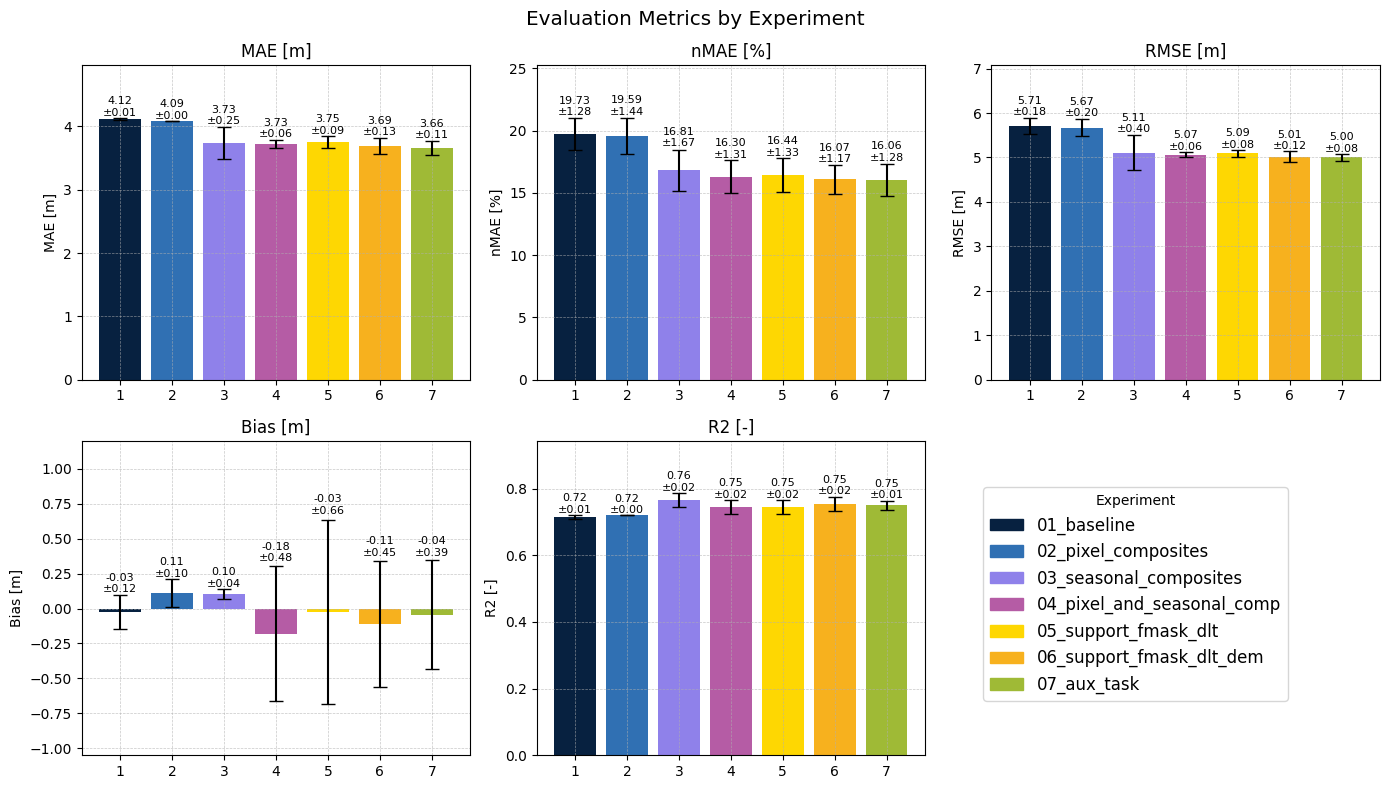

In [27]:
# Batch 128, epochs up to 500
eval.plot_experiment_metrics_multiple_runs(df_big, title=None, printout=True)

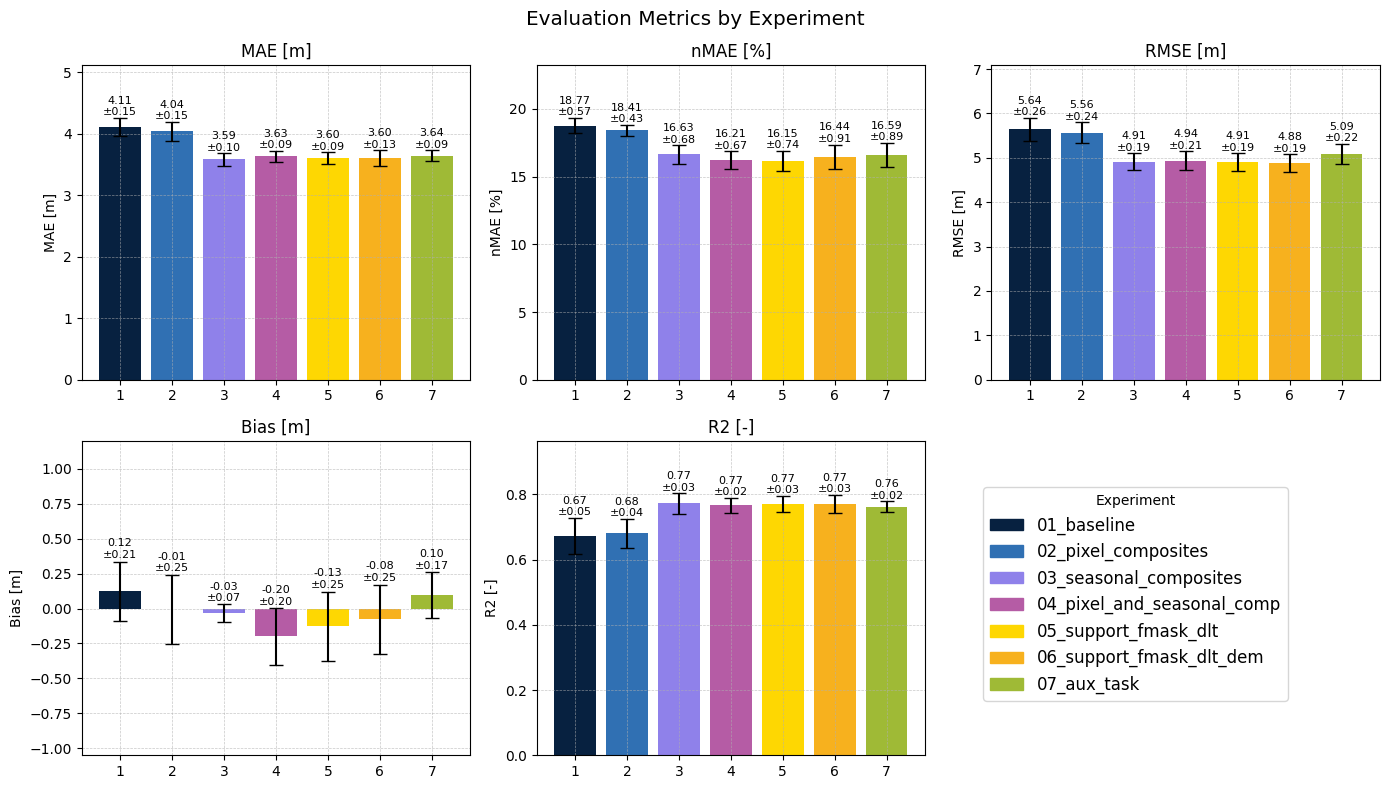

In [259]:
# Batch 128, epochs up to 500
eval.plot_experiment_metrics_multiple_runs(df_big, title=None, printout=True)

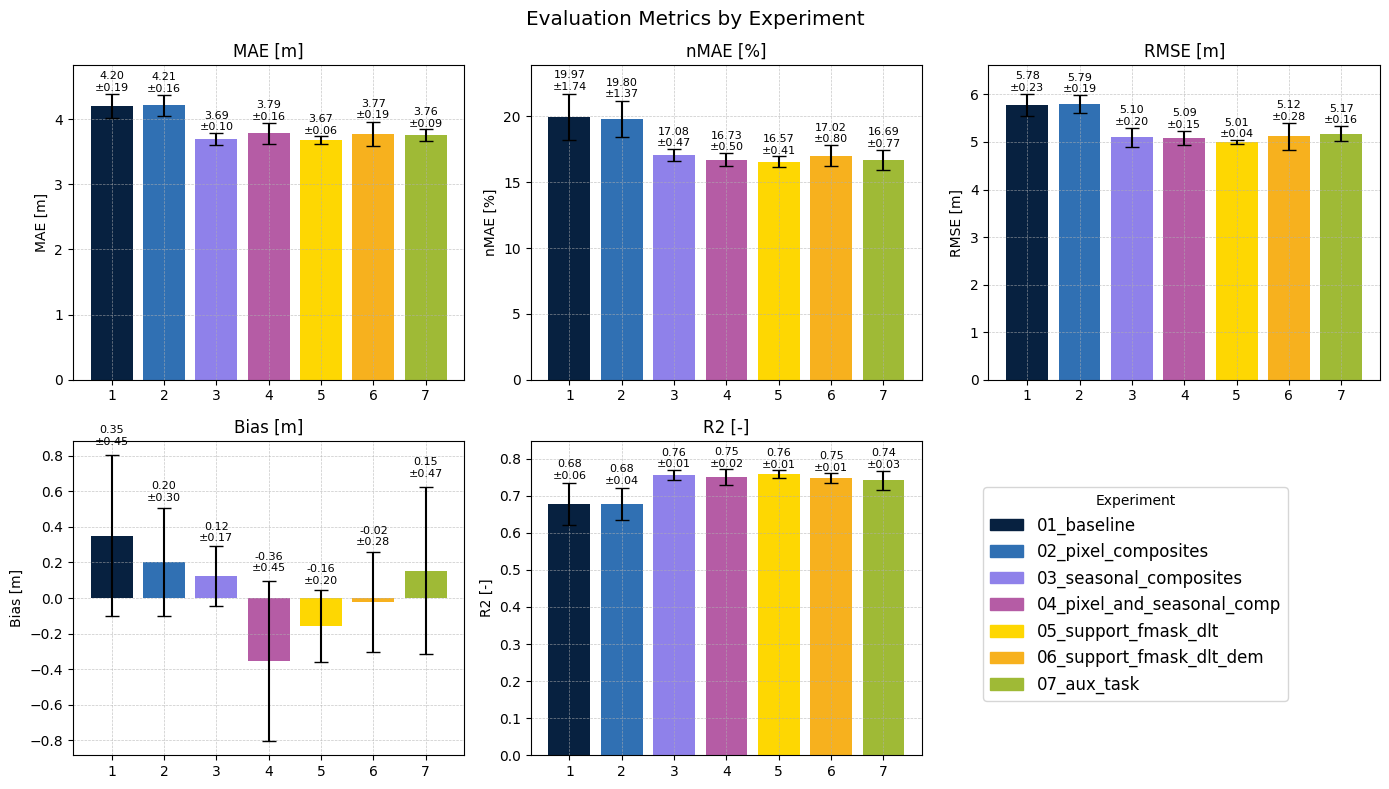

In [225]:
eval.plot_experiment_metrics_multiple_runs(df_big, title=None, printout=True)

## 250 epochs, batchsize 32

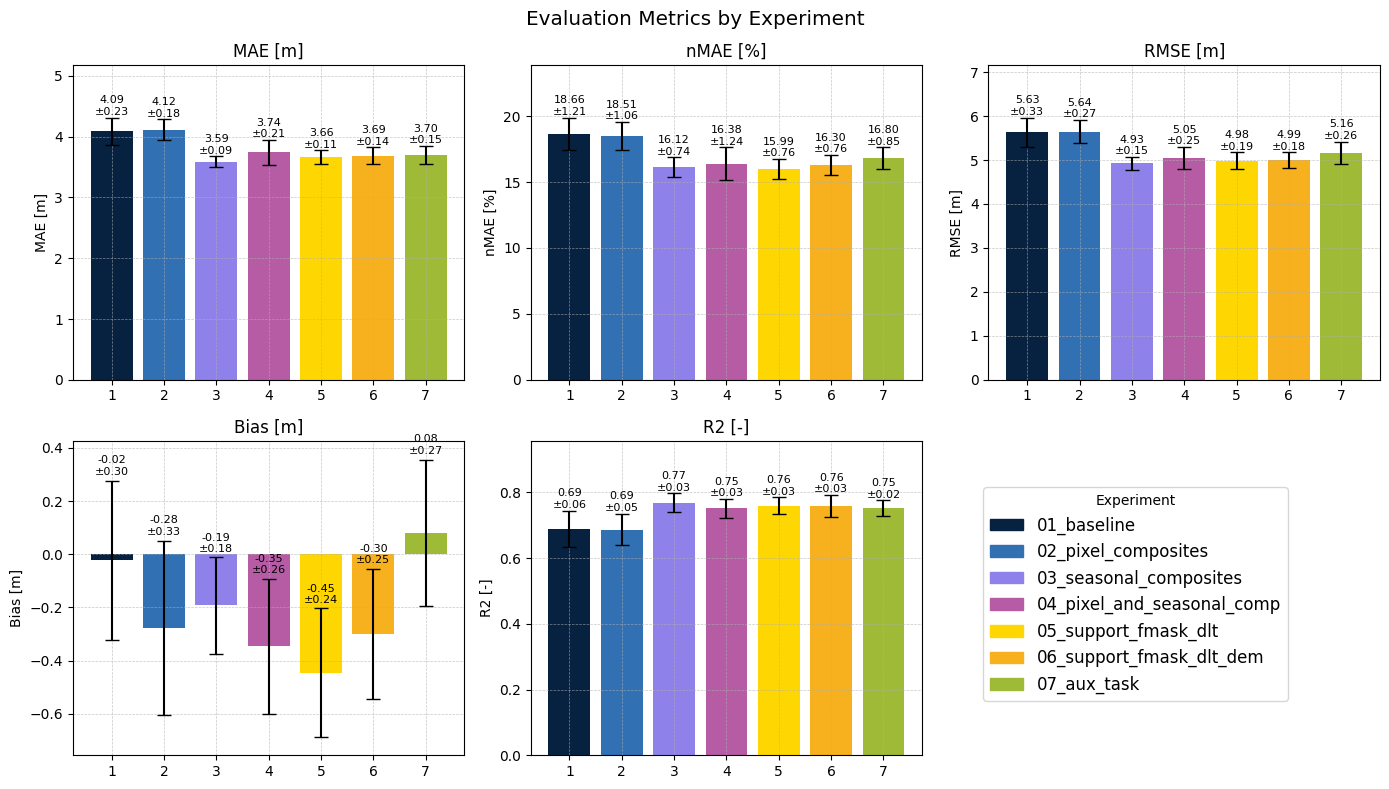

In [235]:
eval.plot_experiment_metrics_multiple_runs(df_big, title=None, printout=True)

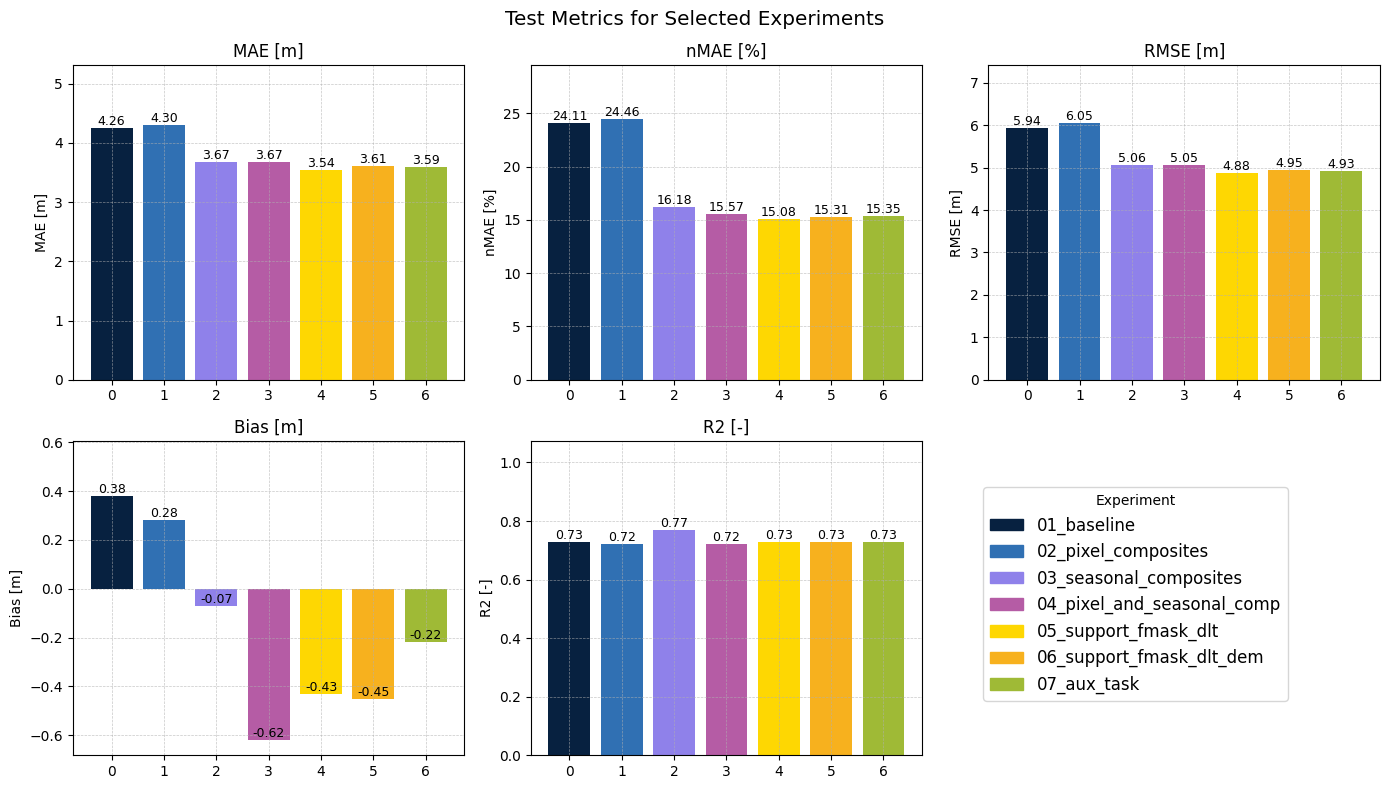

In [252]:
eval.plot_experiment_metrics_test_only(df_result, title="Test Metrics for Selected Experiments", printout=True)

### archive

In [ ]:
import seaborn as sns
from matplotlib.cm import get_cmap

def plot_experiment_metrics(df):
    """
    Plot MAE, nMAE, RMSE, and Bias for Test and Val in grouped barplots,
    hued by experiment name (first column).
    Args:
        df (pd.DataFrame): DataFrame containing metrics for different experiments.
    """
    metrics = [
        ("MAE [m] (Val)", "MAE [m] (Test)"),
        ("nMAE [%] (Val)", "nMAE [%] (Test)"),
        ("RMSE [m] (Val)", "RMSE [m] (Test)"),
        ("Bias [m] (Val)", "Bias [m] (Test)")
    ]
    metric_labels = ["MAE", "nMAE", "RMSE", "Bias"]

    exp_col = df.columns[0]
    exp_names = df[exp_col].tolist()

    # Define experiment groups and colors
    group_map = {
        0: "Baseline",
        1: "CompositeA",
        2: "CompositeB",
        3: "CompositeC",
        4: "AuxLayerA",
        5: "AuxLayerB",
        6: "MidTraining",
    }
    # Use a set of neutral but visually distinct colors from the 'viridis' colormap

    viridis = plt.get_cmap('nipy_spectral')
    # Custom color indices: 0, 0.25, 0.3, 0.35, 0.6, 0.65, 0.85
    color_indices = [0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.9]
    group_colors = {group: viridis(idx) for group, idx in zip(group_map.values(), color_indices)}

    # Assign experiment group to each experiment
    exp_to_group = {exp_names[i]: group_map.get(i, "Other") for i in range(len(exp_names))}
    palette = {exp: group_colors[exp_to_group[exp]] for exp in exp_names}

    # Prepare melted dataframe for plotting
    df_melted = pd.melt(
        df,
        id_vars=exp_col,
        value_vars=[m for pair in metrics for m in pair],
        var_name="MetricType",
        value_name="Value"
    )
    df_melted["Metric"] = df_melted["MetricType"].apply(lambda x: x.split()[0])
    df_melted["Group"] = df_melted[exp_col].map(exp_to_group)

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    handles, labels = None, None
    for i, (label, _) in enumerate(metrics):
        ax = axes[i // 2, i % 2]
        ax.grid()
        metric_group = df_melted[df_melted["Metric"] == label.split()[0]]
        bar = sns.barplot(
            data=metric_group,
            x="MetricType",
            y="Value",
            hue=exp_col,
            ax=ax,
            palette=palette,
            errorbar=None
        )
        ax.set_title(label.split()[0])
        ax.set_xlabel("")
        ax.set_ylabel("Value")
        ax.tick_params(axis='x', rotation=30)
        
        if handles is None and labels is None:
            handles, labels = ax.get_legend_handles_labels()
            print(handles, labels)
        ax.get_legend().remove()
    fig.legend(handles, labels, title="Experiment", loc="center left", bbox_to_anchor=(0.9, 0.5), fontsize='large')
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()


## config vizualizer

In [83]:
def plot_experiment_matrix(experiments, order_exps=None, figsize=(14, 6), cmap="Greens"):
  """
  Visualize experiment configs as a binary/config matrix.
  Rows = experiments (index), Columns = features:
    - spectral seasons (prefixed 'season:')
    - spectral quantiles (prefixed 'quantile:')
    - aux inputs (prefixed 'aux:')
    - outputs (prefixed 'out:'; annotated with loss/weight when available)
    - strategy (prefixed 'strategy:')
  A colored cell indicates presence; annotation shows 'x' for simple presence
  or for outputs shows "<loss>|w=<weight>" if available.

  Args:
    experiments (dict): mapping experiment_name -> config dict
    order_exps (list, optional): list of experiment names to control row order
    figsize (tuple): matplotlib figure size
    cmap (str): colormap for seaborn.heatmap
  Returns:
    pd.DataFrame: binary presence matrix (0/1)
  """
  # collect experiment names
  exp_names = list(experiments.keys()) if order_exps is None else order_exps
  # gather all possible columns
  seasons = set()
  quantiles = set()
  aux_inputs = set()
  outputs = set()
  strategies = set()

  for name in exp_names:
    cfg = experiments.get(name, {})
    spec = cfg.get("spectral", {}) or {}
    s = spec.get("seasons", []) or []
    q = spec.get("quantiles", []) or []
    for si in s: seasons.add(si)
    for qi in q: quantiles.add(qi)
    for ai in (cfg.get("aux_inputs") or []): aux_inputs.add(ai)
    for out_name in (cfg.get("outputs") or {}).keys(): outputs.add(out_name)
    strategies.add(cfg.get("strategy", "None"))

  # build ordered column list
  col_list = []
  # strategy columns (one-hot)
  strat_cols = [f"strategy:{s}" for s in sorted(strategies)]
  col_list.extend(strat_cols)
  # spectral
  season_cols = [f"season:{s}" for s in sorted(seasons)]
  quantile_cols = [f"quantile:{q}" for q in sorted(quantiles)]
  col_list.extend(season_cols)
  col_list.extend(quantile_cols)
  # aux inputs
  aux_cols = [f"aux:{a}" for a in sorted(aux_inputs)]
  col_list.extend(aux_cols)
  # outputs
  out_cols = [f"out:{o}" for o in sorted(outputs)]
  col_list.extend(out_cols)

  # prepare matrices
  mat = pd.DataFrame(0, index=exp_names, columns=col_list, dtype=int)
  annot = pd.DataFrame("", index=exp_names, columns=col_list)

  for name in exp_names:
    cfg = experiments.get(name, {}) or {}
    # strategy
    strat = cfg.get("strategy", None)
    if strat is not None:
      col = f"strategy:{strat}"
      if col in mat.columns:
        mat.at[name, col] = 1
        annot.at[name, col] = "x"
    # spectral
    spec = cfg.get("spectral", {}) or {}
    for s in spec.get("seasons", []) or []:
      col = f"season:{s}"
      if col in mat.columns:
        mat.at[name, col] = 1
        annot.at[name, col] = "x"
    for q in spec.get("quantiles", []) or []:
      col = f"quantile:{q}"
      if col in mat.columns:
        mat.at[name, col] = 1
        annot.at[name, col] = "x"
    # aux inputs
    for a in cfg.get("aux_inputs", []) or []:
      col = f"aux:{a}"
      if col in mat.columns:
        mat.at[name, col] = 1
        annot.at[name, col] = "x"
    # outputs: annotate with loss and weight if present
    for out_name, out_cfg in (cfg.get("outputs") or {}).items():
      col = f"out:{out_name}"
      if col in mat.columns:
        mat.at[name, col] = 1
        loss = out_cfg.get("loss")
        weight = out_cfg.get("weight")
        if loss is None and weight is None:
          annot.at[name, col] = "x"
        else:
          pieces = []
          if loss is not None:
            pieces.append(str(loss))
          if weight is not None:
            pieces.append(f"w={weight}")
          annot.at[name, col] = "|".join(pieces)

  # Plot with seaborn heatmap and string annotations
  import seaborn as sns  # seaborn is available in notebook; import again is harmless
  plt.figure(figsize=figsize)
  ax = sns.heatmap(mat, cmap=cmap, cbar=False, linewidths=0.5, linecolor="#dddddd",
           annot=annot.values, fmt="", annot_kws={"fontsize": 9}, vmin=0, vmax=1)
  ax.set_ylabel("")  # experiments are rows already
  ax.set_xlabel("")  # columns explain themselves
  ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
  plt.title("Experiment configuration mapping (x = present; outputs show loss|w=weight)")
  plt.tight_layout()
  plt.show()

  return mat

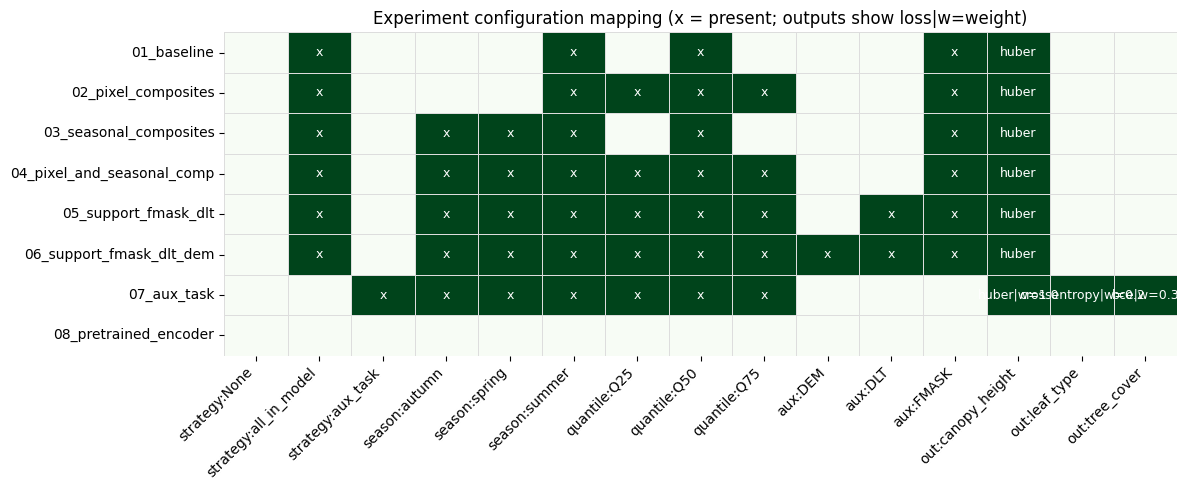

strategy:None  strategy:all_in_model  \
01_baseline                             0                      1   
02_pixel_composites                     0                      1   
03_seasonal_composites                  0                      1   
04_pixel_and_seasonal_comp              0                      1   
05_support_fmask_dlt                    0                      1   
06_support_fmask_dlt_dem                0                      1   
07_aux_task                             0                      0   
08_pretrained_encoder                   0                      0   

                            strategy:aux_task  season:autumn  season:spring  \
01_baseline                                 0              0              0   
02_pixel_composites                         0              0              0   
03_seasonal_composites                      0              1              1   
04_pixel_and_seasonal_comp                  0              1              1   
05_support_fmask_dlt                        0              1              1   
06_support_fmask_dlt_dem                    0              1              1   
07_aux_task                                 1              1              1   
08_pretrained_encoder                       0              0              0   

                            season:summer  quantile:Q25  quantile:Q50  \
01_baseline                             1             0             1   
02_pixel_composites                     1             1             1   
03_seasonal_composites                  1             0             1   
04_pixel_and_seasonal_comp              1             1             1   
05_support_fmask_dlt                    1             1             1   
06_support_fmask_dlt_dem                1             1             1   
07_aux_task                             1             1             1   
08_pretrained_encoder                   0             0             0   

                            quantile:Q75  aux:DEM  aux:DLT  aux:FMASK  \
01_baseline                            0        0        0          1   
02_pixel_composites                    1        0        0          1   
03_seasonal_composites                 0        0        0          1   
04_pixel_and_seasonal_comp             1        0        0          1   
05_support_fmask_dlt                   1        0        1          1   
06_support_fmask_dlt_dem               1        1        1          1   
07_aux_task                            1        0        0          0   
08_pretrained_encoder                  0        0        0          0   

                            out:canopy_height  out:leaf_type  out:tree_cover  
01_baseline                                 1              0               0  
02_pixel_composites                         1              0               0  
03_seasonal_composites                      1              0               0  
04_pixel_and_seasonal_comp                  1              0               0  
05_support_fmask_dlt                        1              0               0  
06_support_fmask_dlt_dem                    1              0               0  
07_aux_task                                 1              1               1  
08_pretrained_encoder                       0              0               0

In [84]:
plot_experiment_matrix(experiments, figsize=(12, 5), cmap="Greens")

## joint plots

In [363]:
run_ids= ["251024_FINAL_" + str(i) for i in range(5)]

In [483]:
run_ids= ["251024_FINAL_" + str(i) for i in range(5)]
run_ids = ["251028_PATCHSYNC_0"]
dfall = pd.DataFrame()  # cols: experiment, preds, targets, run_id
dfpatch = pd.DataFrame() #keeps the patch structure.

# SELECT EXPERIMENTAL CONFIG
for run_id in tqdm(run_ids):
    with open('../configs/experiments.yaml', 'r') as f:
        experiments = yaml.safe_load(f)
        # experiment_names = list(experiments.keys())
        #run_id = "251009_4" #"250929_02" #"250930_1"
        exp_dir = os.path.join("..", "results", run_id, "train")
        experiment_names = sorted(
            [name for name in os.listdir(exp_dir) if os.path.isdir(os.path.join(exp_dir, name))]
        )
        #experiment_names = experiment_names[6:7]  # Select the first 7 experiment names
        print("Available experiments:", experiment_names)

    # Prepare lists to collect all predictions, targets, and experiment names across all runs
    if 'all_preds' not in locals():
        all_preds = []
        all_targets = []
        all_exp_names = []
        all_run_ids = []

    for exp_name in experiment_names:
        sites, cfg = cf.get_config(exp_name)
        #global_config = md.global_config
        model_weights, logs, cfg = md.load_results(exp_name, run_id)
        preds_val, targets_val, preds_test, targets_test, maskval, masktest, rgb_test = [None] * 7
        preds_val, targets_val, preds_test, targets_test, maskval, masktest, rgb_test = md.load_np_stacks(exp_name, run_id)
        # Take only the first channel [:,0,:,:], flatten, and drop masked values
        preds_flat = preds_test[:, 0, :, :].reshape(-1)
        targets_flat = targets_test[:, 0, :, :].reshape(-1)
        mask_flat = masktest[:, 0, :, :].reshape(-1).astype(bool)
        # Keep only unmasked values (mask==1)
        valid_idx = mask_flat
        preds_valid = preds_flat[valid_idx]
        targets_valid = targets_flat[valid_idx]

        # Append to dfall DataFrame with current exp_name and run_id
        df_tmp = pd.DataFrame({
            "experiment": exp_name,
            "run_id": run_id,
            "preds": preds_valid,
            "targets": targets_valid, 
            'seed': cfg['seed']
        })
        dfall = pd.concat([dfall, df_tmp], ignore_index=True)

        # fill dfpatch like with dfall, but it shall keep the shape of the patch (last two dims are 32x32). so a df, with N samples per run_id and exp name. each object has the shape (1,32,32)
        # preds_test, targets_test, masktest shape: (N, 1, 32, 32)
        # We'll keep only unmasked patches (mask==1 for all elements in patch)
        n_patches = preds_test.shape[0]
        for i in range(n_patches):
            patch_mask = masktest[i, 0, :, :]
            if 1:  # keep patches with at least some valid pixels
                patch_pred = preds_test[i, 0, :, :]
                patch_target = targets_test[i, 0, :, :]
                patch_mask_bool = patch_mask.astype(bool)
                dfpatch = pd.concat([
                    dfpatch,
                    pd.DataFrame({
                    "experiment": [exp_name],
                    "run_id": [run_id],
                    "PatchNum": i,
                    "preds_patch": [patch_pred.copy()],
                    "targets_patch": [patch_target.copy()],
                    "mask_patch": [patch_mask_bool.copy()],
                    "rgb_patch": [rgb_test[i,:,:,:].copy()],
                    "seed": [cfg['seed']]
                    })
                ], ignore_index=True)


  0%|          | 0/1 [00:00<?, ?it/s]

Available experiments: ['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]


In [456]:
dfpatch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1282 entries, 0 to 1281
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   experiment     1282 non-null   object
 1   run_id         1282 non-null   object
 2   PatchNum       1282 non-null   int64 
 3   preds_patch    1282 non-null   object
 4   targets_patch  1282 non-null   object
 5   mask_patch     1282 non-null   object
 6   rgb_patch      1282 non-null   object
 7   seed           1282 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 80.3+ KB


In [457]:
dfpatch

experiment              run_id  PatchNum  \
0     01_baseline  251028_PATCHSYNC_0         0   
1     01_baseline  251028_PATCHSYNC_0         1   
2     01_baseline  251028_PATCHSYNC_0         2   
3     01_baseline  251028_PATCHSYNC_0         3   
4     01_baseline  251028_PATCHSYNC_0         4   
...           ...                 ...       ...   
1277  07_aux_task  251028_PATCHSYNC_0       166   
1278  07_aux_task  251028_PATCHSYNC_0       167   
1279  07_aux_task  251028_PATCHSYNC_0       168   
1280  07_aux_task  251028_PATCHSYNC_0       169   
1281  07_aux_task  251028_PATCHSYNC_0       170   

                                            preds_patch  \
0     [[30.966244, 31.690271, 32.149887, 32.20075, 3...   
1     [[26.807245, 26.983513, 28.965881, 30.957321, ...   
2     [[27.2013, 27.932219, 29.968317, 30.96612, 30....   
3     [[9.278713, 3.5526333, 2.9380684, 2.6531296, 2...   
4     [[29.607502, 30.400534, 31.160658, 30.827341, ...   
...                                                 ...   
1277  [[29.120077, 28.170876, 28.020512, 27.867313, ...   
1278  [[26.655394, 26.476135, 26.902426, 26.24087, 2...   
1279  [[27.86467, 28.565508, 28.52176, 28.413454, 28...   
1280  [[26.772703, 27.291853, 27.893724, 28.815601, ...   
1281  [[30.873333, 31.745668, 32.215763, 32.708366, ...   

                                          targets_patch  \
0     [[26.763, 35.12, 35.12, 35.12, 32.309, 31.794,...   
1     [[-42.287956, 34.736, 34.736, 35.606, 35.606, ...   
2     [[19.79, 15.98, 26.08, 27.62, 30.96, 32.73, 27...   
3     [[0.010000229, 0.010000229, 0.020000458, 0.010...   
4     [[38.4, 39.38, 37.75, 38.74, 39.45, 34.66, 37....   
...                                                 ...   
1277  [[28.11, 23.23, 26.73, 31.55, 32.23, 31.87, 31...   
1278  [[28.09, 26.58, 28.49, 31.71, 30.88, 32.04, 29...   
1279  [[33.01, 32.03, 31.96, 33.45, 31.07, 32.45, 30...   
1280  [[30.298, 26.574, 29.608, 29.608, 35.143, 35.1...   
1281  [[-42.287956, 26.976, 30.296, 32.042, 32.042, ...   

                                             mask_patch  \
0     [[True, True, True, True, True, True, True, Tr...   
1     [[False, True, True, True, True, True, True, T...   
2     [[True, True, True, True, True, True, True, Tr...   
3     [[True, True, True, True, True, True, True, Tr...   
4     [[True, True, True, True, True, True, True, Tr...   
...                                                 ...   
1277  [[True, True, True, True, True, True, True, Tr...   
1278  [[True, True, True, True, True, True, True, Tr...   
1279  [[True, True, True, True, True, True, True, Tr...   
1280  [[True, True, True, True, True, True, True, Tr...   
1281  [[False, True, True, True, True, True, True, T...   

                                              rgb_patch  seed  
0     [[[0.03551438, 0.025091682, 0.024512643, 0.025...    50  
1     [[[0.055008687, 0.05462266, 0.055201698, 0.055...    50  
2     [[[0.04222874, 0.024633432, 0.0, 0.007038123, ...    50  
3     [[[0.18064517, 0.19530791, 0.20645161, 0.20293...    50  
4     [[[0.055718474, 0.052199412, 0.052785926, 0.06...    50  
...                                                 ...   ...  
1277  [[[0.06568915, 0.06099707, 0.06979472, 0.06217...    50  
1278  [[[0.06116208, 0.08999563, 0.05941459, 0.04193...    50  
1279  [[[0.056304984, 0.052199412, 0.04457478, 0.052...    50  
1280  [[[0.12430033, 0.09148813, 0.06987068, 0.06041...    50  
1281  [[[0.034549315, 0.033391237, 0.03146111, 0.026...    50  

[1282 rows x 8 columns]

### residuals over gt

In [621]:
import pandas as pd

def plot_residuals_nmae_bias_vs_gt(df, bins=50, title="Residuals, nMAE, Bias vs. GT Distribution"):
    """
    Plot 3 subplots: 1) MAE (residuals), 2) nMAE, 3) Bias, each vs. ground truth, 
    with scaled GT distribution overlay. 
    The GT distribution is scaled to the max of the respective metric.
    Additional row: boxplots of metrics for selected experiments across GT bins (hued by experiment).
    """
    import numpy as np
    from scipy import stats
    import matplotlib.pyplot as plt
    import seaborn as sns

    palette = ['#072140', '#3070B3', '#8F81EA', '#B55CA5', '#FED702', '#F7B11E', '#9FBA36']
    
    experiments = df['experiment'].unique()
    subset_exp = ['01_baseline', '04_pixel_and_seasonal', '06_support_fmask_dlt_dem', '07_aux_task']
    selected_experiments = [e for e in experiments if any(x in e for x in experiments )]
    
    fig, axes = plt.subplots(2, 3, figsize=(14, 8))

    gt_all = df['targets'].values
    hist_gt, bin_edges_gt = np.histogram(gt_all, bins=bins, range=(0, 50))
    hist_gt = hist_gt / hist_gt.max()
    bin_centers_gt = (bin_edges_gt[:-1] + bin_edges_gt[1:]) / 2

    max_mae, max_nmae, max_bias, min_bias = 0, 0, 0, 0
    metrics = {exp: {} for exp in experiments}

    for exp in experiments:
        sub = df[df['experiment'] == exp]
        preds = sub['preds'].values
        targets = sub['targets'].values
        errors = preds - targets

        bin_mae, bin_edges, _ = stats.binned_statistic(targets, abs(errors), statistic='mean', bins=bins)
        bin_counts, _, _ = stats.binned_statistic(targets, targets, statistic='count', bins=bin_edges)
        mask = bin_counts < 10
        bin_mae[mask] = np.nan
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        max_mae = max(max_mae, np.nanquantile(bin_mae, 0.9))
        metrics[exp]['mae'] = (bin_centers, bin_mae)

        mask_range = (targets >= 2) & (targets <= 60)
        nmae = (np.abs(errors[mask_range]) / targets[mask_range]) * 100
        bin_nmae, bin_edges_nmae, _ = stats.binned_statistic(targets[mask_range], nmae, statistic='mean', bins=bins)
        bin_counts_nmae, _, _ = stats.binned_statistic(targets[mask_range], targets[mask_range], statistic='count', bins=bin_edges_nmae)
        mask_nmae = bin_counts_nmae < 10
        bin_nmae[mask_nmae] = np.nan
        bin_centers_nmae = (bin_edges_nmae[:-1] + bin_edges_nmae[1:]) / 2
        max_nmae = max(max_nmae, np.nanmax(bin_nmae))
        metrics[exp]['nmae'] = (bin_centers_nmae, bin_nmae)

        bin_bias, bin_edges_bias, _ = stats.binned_statistic(targets, errors, statistic='mean', bins=bins)
        bin_counts_bias, _, _ = stats.binned_statistic(targets, targets, statistic='count', bins=bin_edges_bias)
        mask_bias = bin_counts_bias < 10
        bin_bias[mask_bias] = np.nan
        bin_centers_bias = (bin_edges_bias[:-1] + bin_edges_bias[1:]) / 2
        max_bias = max(max_bias, np.nanquantile(np.abs(bin_bias), 0.9))
        min_bias = min(min_bias, np.nanquantile(bin_bias, 0.1))
        metrics[exp]['bias'] = (bin_centers_bias, bin_bias)

    # Plot lines with palette for selected_experiments, gray for others
    handles = []
    labels = []
    for idx, exp in enumerate(experiments):
        color = palette[selected_experiments.index(exp)] if exp in selected_experiments else 'gray'
        l0, = axes[0, 0].plot(*metrics[exp]['mae'], label=exp, color=color)
        l1, = axes[0, 1].plot(*metrics[exp]['nmae'], label=exp, color=color)
        l2, = axes[0, 2].plot(*metrics[exp]['bias'], label=exp, color=color)
        if exp in selected_experiments:
            handles.append(l0)
            labels.append(exp)

    dist = axes[0, 0].plot(bin_centers_gt, hist_gt * max_mae, '--', color='lightgray', label='GT dist (scaled)')
    axes[0, 1].plot(bin_centers_gt, hist_gt * max_nmae, '--', color='lightgray', label='GT dist (scaled)')
    axes[0, 2].plot(bin_centers_gt, hist_gt * max_bias, '--', color='lightgray', label='GT dist (scaled)')
    handles.append(dist[0])
    labels.append("GT density (scaled)")

    axes[0, 0].set_xlabel('Ground Truth [m]')
    axes[0, 0].set_ylabel('MAE [m]')
    axes[0, 0].set_title('MAE vs. Ground Truth')
    axes[0, 0].grid(True)
    axes[0, 0].set_xlim(0, 50)
    axes[0, 0].set_ylim(0, max_mae)

    axes[0, 1].set_xlabel('Ground Truth [m]')
    axes[0, 1].set_ylabel('nMAE [%]')
    axes[0, 1].set_title('NMAE vs. Ground Truth')
    axes[0, 1].grid(True)
    axes[0, 1].set_xlim(0, 50)
    axes[0, 1].set_ylim(0, max_nmae)

    axes[0, 2].set_xlabel('Ground Truth [m]')
    axes[0, 2].set_ylabel('Bias [m]')
    axes[0, 2].set_title('Bias vs. Ground Truth')
    axes[0, 2].grid(True)
    axes[0, 2].set_xlim(0, 50)
    axes[0, 2].set_ylim(min_bias, max_bias)

    gt_bins = [5, 15, 25, 35, 45]
    gt_labels = ['5-15', '15-25', '25-35', '35-45']

    for metric_idx, metric_name in enumerate(['mae', 'nmae', 'bias']):
        boxplot_data = []
        
        for gt_bin_idx, (bin_low, bin_high) in enumerate(zip(gt_bins[:-1], gt_bins[1:])):
            for exp in selected_experiments:
                sub = df[df['experiment'] == exp]
                preds = sub['preds'].values
                targets = sub['targets'].values
                errors = preds - targets

                if metric_name == 'mae':
                    values = np.abs(errors)
                elif metric_name == 'nmae':
                    mask_range = (targets >= 2) & (targets <= 60)
                    values = (np.abs(errors[mask_range]) / targets[mask_range]) * 100
                    targets = targets[mask_range]
                else:
                    values = errors

                mask = (targets >= bin_low) & (targets < bin_high)
                if mask.sum() > 0:
                    for val in values[mask]:
                        boxplot_data.append({'value': val, 'gt_bin': gt_labels[gt_bin_idx], 'experiment': exp})

        boxplot_df = pd.DataFrame(boxplot_data)
        sns.boxplot(data=boxplot_df, x='gt_bin', y='value', hue='experiment', ax=axes[1, metric_idx],
                    palette=palette[:len(selected_experiments)], showfliers=False)
        axes[1, metric_idx].set_xlabel('Ground Truth Bin [m]')
        axes[1, metric_idx].set_ylabel(('MAE [m]' if metric_name == 'mae' else 
                                         'nMAE [%]' if metric_name == 'nmae' else 'Bias [m]'))
        axes[1, metric_idx].set_title(f'{metric_name.upper()} Statistics by GT Bin')
        axes[1, metric_idx].grid(True, alpha=0.3, axis='y')
        axes[1, metric_idx].legend_.remove()  # Remove individual legends
    
    #axes[0,2] add a black line at y=0
    axes[0,2].axhline(0, color='black', linestyle='-', linewidth=1)
    axes[1,2].axhline(0, color='black', linestyle='-', linewidth=1)


    axes[1,0].set_ylim(0,30)
    axes[1,1].set_ylim(0,120)
    # One legend for all, outside on the right
    #fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.005, 0.5), borderaxespad=0., title='Experiment')
    title = "MAE, nMAE, Bias vs. GT Distribution \n dashed line: GT CHM density (scaled)"
    fig.suptitle(title, fontsize=16)
    plt.tight_layout()
    return fig


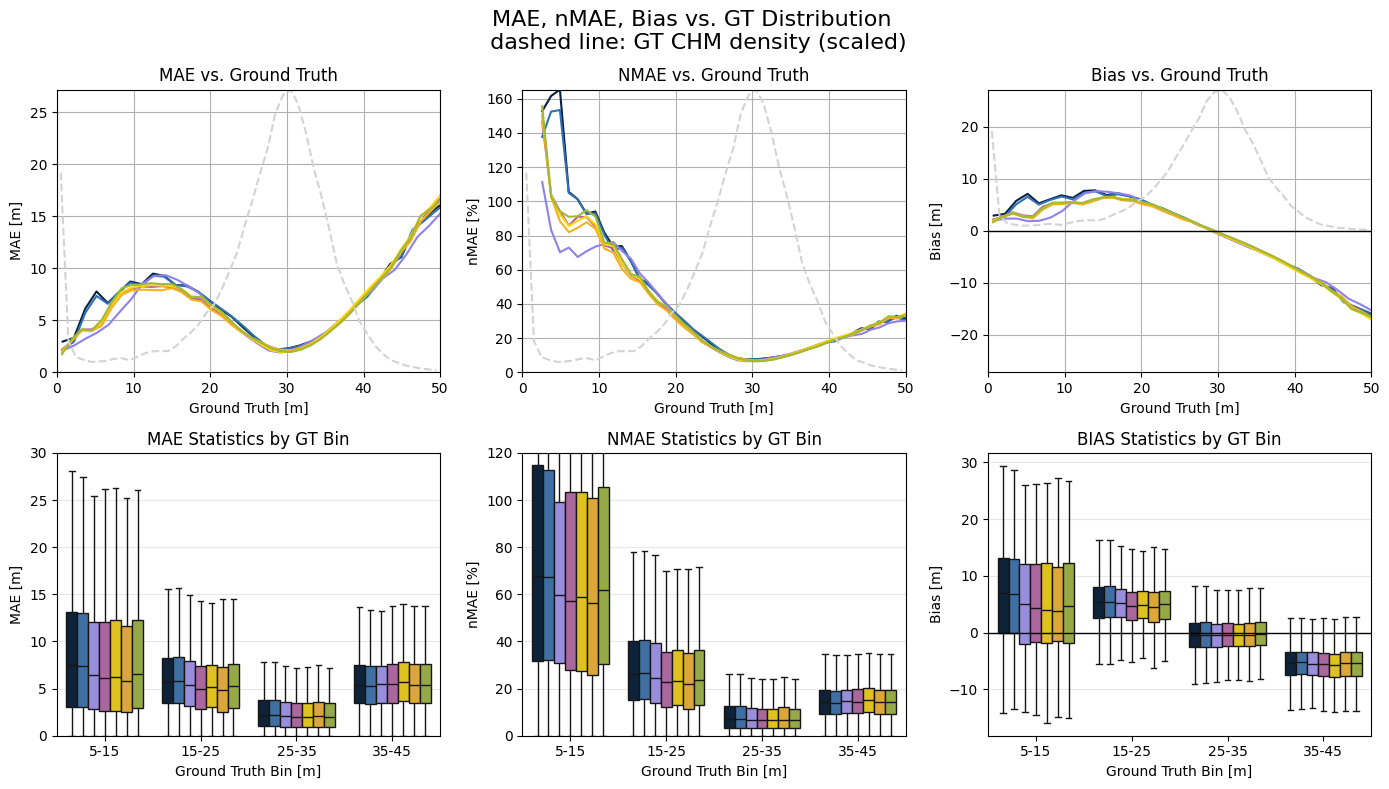

In [623]:
fig = plot_residuals_nmae_bias_vs_gt(dfall,title="Metrics vs. Ground Truth CHM")
fig.savefig("../results/all_in/final/metrics_vs_gt_all_runs.png", dpi=300, bbox_inches='tight')


### scatter heatmap

/var/folders/0s/1cgzkm553c3gm9c4dkbzdh680000gn/T/ipykernel_24023/2357876027.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.91, 1])


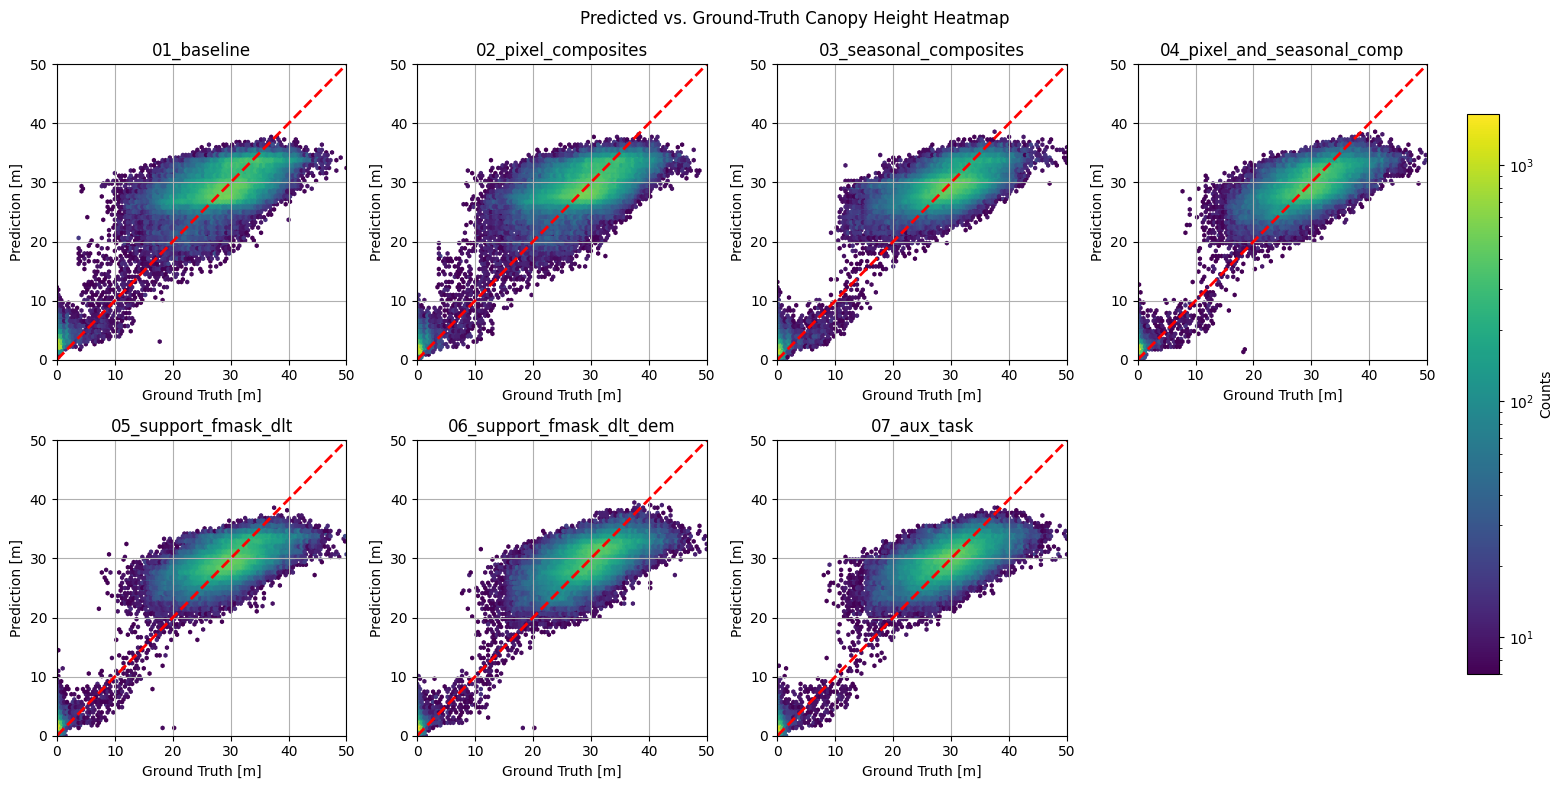

In [590]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assume dfall exists as in previous cells, with columns: "experiment", "preds", "targets"
experiments = dfall['experiment'].unique()
n_exp = len(experiments)
ncols = min(4, n_exp)
nrows = (n_exp + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), squeeze=False)

# Find global min and max counts across all experiments
global_vmin, global_vmax = 7, 0
for exp in experiments:
    sub = dfall[dfall['experiment'] == exp]
    hb_temp = axes[0, 0].hexbin(
        sub['targets'], sub['preds'],
        gridsize=100, extent=(0, 50, 0, 50), mincnt=global_vmin
    )
    counts = hb_temp.get_array()
    if len(counts) > global_vmin:
        global_vmin = min(global_vmin, counts.min())
        global_vmax = max(global_vmax, counts.max())
    hb_temp.remove()

# Ensure log scale applies correctly
global_vmin = max(global_vmin, 1)  # Avoid log(0)

for idx, exp in enumerate(experiments):
    ax = axes[idx // ncols, idx % ncols]
    sub = dfall[dfall['experiment'] == exp]
    hb = ax.hexbin(
        sub['targets'], sub['preds'],
        gridsize=100, cmap='viridis', bins='log', extent=(0, 50, 0, 50),
        mincnt=global_vmin, vmin=global_vmin, vmax=global_vmax
    )
    # Add ideal line y=x
    ax.plot([0, 50], [0, 50], color='red', linestyle='--', linewidth=2, label='Ideal')
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 50)
    ax.set_title(exp)
    ax.set_xlabel('Ground Truth [m]')
    ax.set_ylabel('Prediction [m]')
    ax.grid(True)

# Add single shared colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.matplotlib.colors.LogNorm(vmin=global_vmin, vmax=global_vmax))
sm.set_array([])
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('Counts')

plt.suptitle("Predicted vs. Ground-Truth Canopy Height Heatmap")

# Hide any unused subplots
for i in range(n_exp, nrows * ncols):
    axes[i // ncols, i % ncols].axis('off')

plt.tight_layout(rect=[0, 0, 0.91, 1])
path = "../results/all_in/final/metrics/scatter_density.png" 
fig.savefig(path)

plt.show()



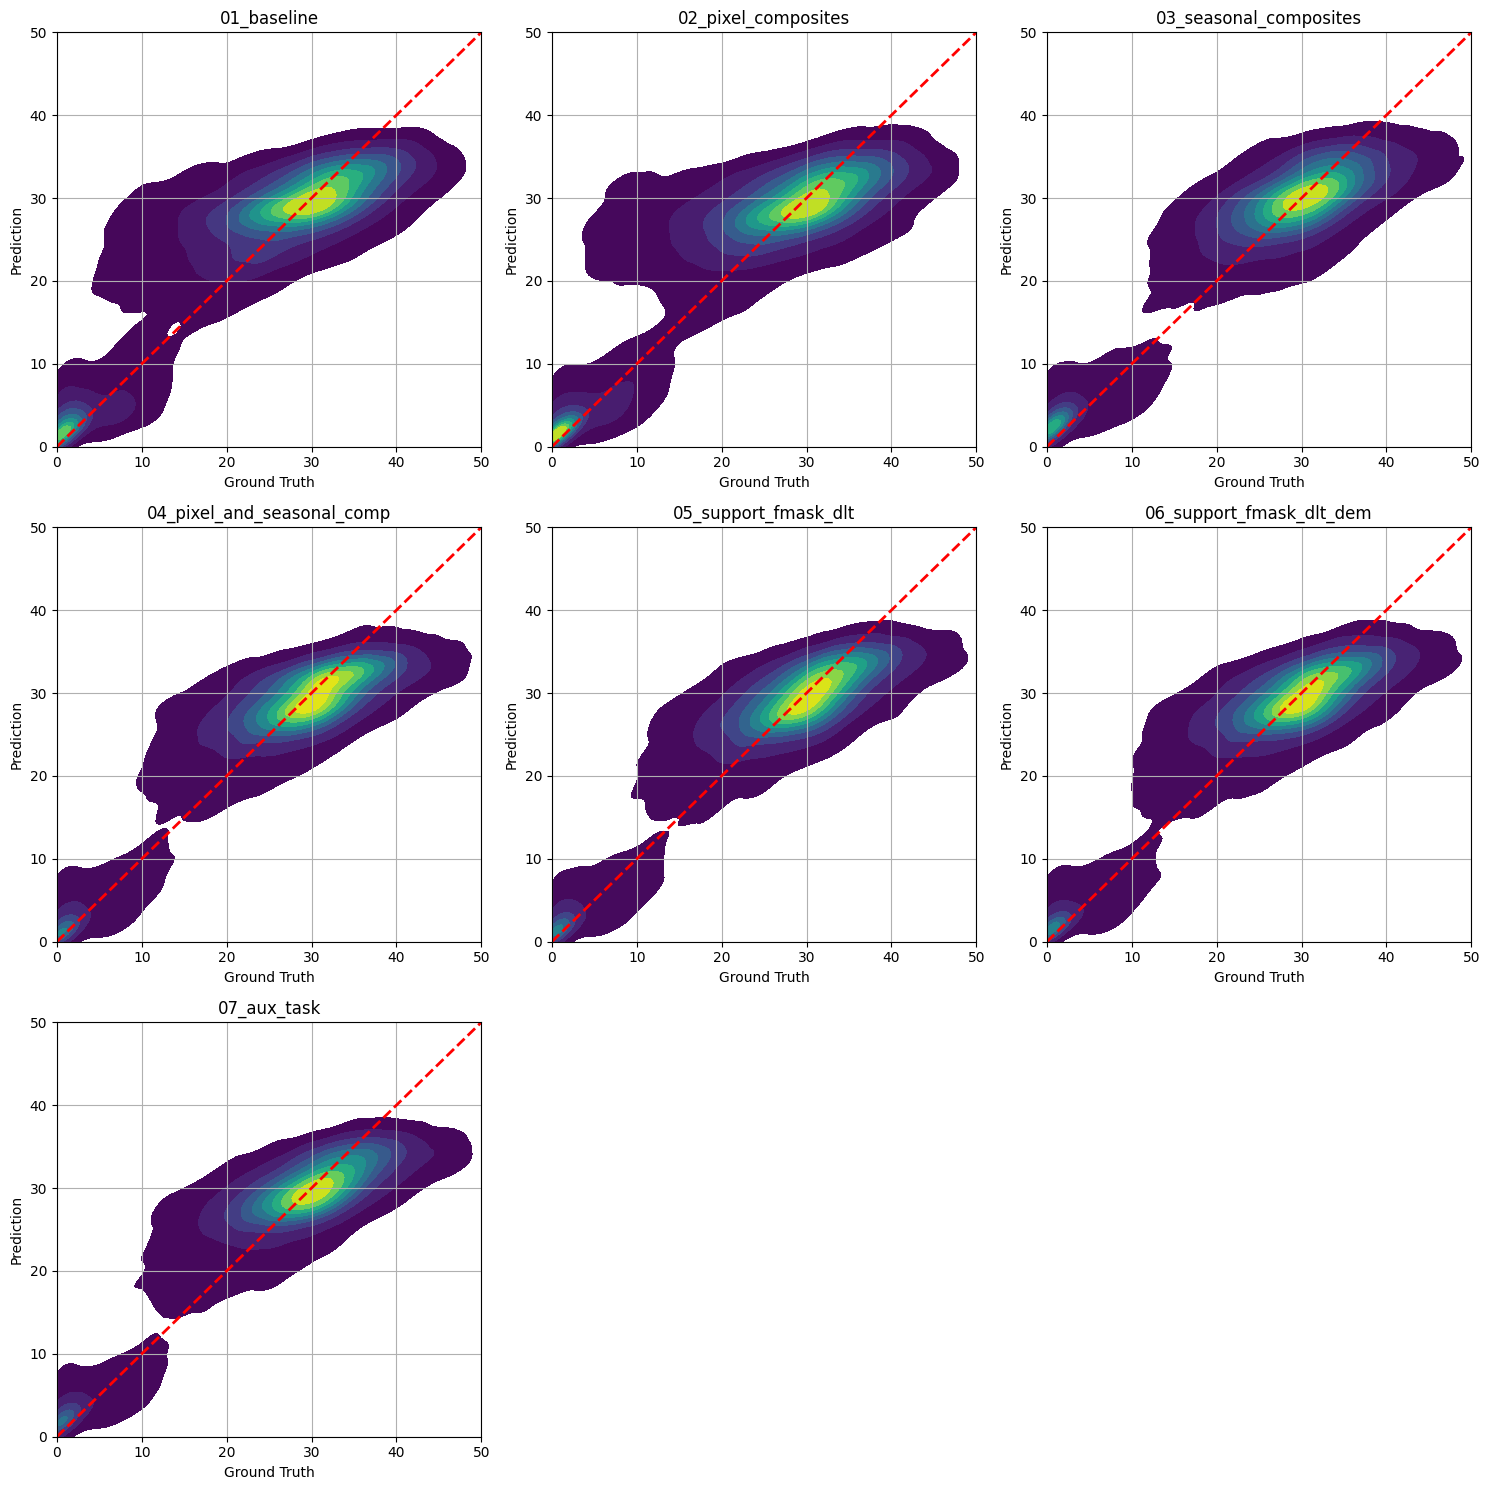

In [284]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assume dfall exists as in previous cells, with columns: "experiment", "preds", "targets"
experiments = dfall['experiment'].unique()
n_exp = len(experiments)
ncols = min(3, n_exp)
nrows = (n_exp + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows), squeeze=False)

for idx, exp in enumerate(experiments):
    ax = axes[idx // ncols, idx % ncols]
    sub = dfall[dfall['experiment'] == exp]
    sns.kdeplot(
        x=sub['targets'],
        y=sub['preds'],
        cmap='viridis',
        fill=True,
        thresh=0.04,
        ax=ax
    )
    # Add ideal line y=x
    ax.plot([0, 50], [0, 50], color='red', linestyle='--', linewidth=2, label='Ideal')
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 50)
    ax.set_title(exp)
    ax.set_xlabel('Ground Truth')
    ax.set_ylabel('Prediction')
    ax.grid(True)

# Hide any unused subplots
for i in range(n_exp, nrows * ncols):
    axes[i // ncols, i % ncols].axis('off')

plt.tight_layout()
plt.show()

### overlays:

In [448]:
dfpatch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6410 entries, 0 to 6409
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   experiment     6410 non-null   object
 1   run_id         6410 non-null   object
 2   PatchNum       6410 non-null   int64 
 3   preds_patch    6410 non-null   object
 4   targets_patch  6410 non-null   object
 5   mask_patch     6410 non-null   object
 6   rgb_patch      6410 non-null   object
 7   seed           6410 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 400.8+ KB


In [484]:
def realign_dfpatch_by_targets(dfpatch):
    """
    Realign PatchNum across experiments within each run_id based on matching target patches.
    Only keeps patches that exist in all experiments for a given run_id.
    Patches are sorted by target content to ensure consistent PatchNum across experiments.
    """
    dfpatch_aligned = pd.DataFrame()
    
    for run_id in dfpatch['run_id'].unique():
        run_data = dfpatch[dfpatch['run_id'] == run_id].copy()
        experiments = run_data['experiment'].unique()
        
        # Create a hashable representation of each target patch
        def patch_to_tuple(patch):
            return tuple(patch.flatten())
        
        # Find patches present in all experiments
        patch_sets = {}
        for exp in experiments:
            exp_data = run_data[run_data['experiment'] == exp]
            patch_tuples = {i: patch_to_tuple(exp_data.iloc[i]['targets_patch']) 
                           for i in range(len(exp_data))}
            patch_sets[exp] = patch_tuples
        
        # Find common patch tuples across all experiments
        common_patches = set(patch_sets[experiments[0]].values())
        for exp in experiments[1:]:
            common_patches &= set(patch_sets[exp].values())
        
        # For each experiment, filter to common patches and sort by patch content
        for exp in experiments:
            exp_data = run_data[run_data['experiment'] == exp].copy()
            exp_data['patch_tuple'] = exp_data['targets_patch'].apply(patch_to_tuple)
            
            # Keep only common patches
            exp_data_filtered = exp_data[exp_data['patch_tuple'].isin(common_patches)].copy()
            
            # Sort by patch tuple to ensure consistent ordering
            exp_data_filtered = exp_data_filtered.sort_values('patch_tuple').reset_index(drop=True)
            
            # Reassign PatchNum based on sorted order
            exp_data_filtered['PatchNum'] = range(len(exp_data_filtered))
            
            # Drop the temporary column
            exp_data_filtered = exp_data_filtered.drop('patch_tuple', axis=1)
            
            dfpatch_aligned = pd.concat([dfpatch_aligned, exp_data_filtered], ignore_index=True)
    
    return dfpatch_aligned


In [427]:
def plot_patch_across_experiments(dfpatch, run_id, patch_id):
    """
    For a given run_id and patch_id, plot S2 RGB, ALS GT, Prediction, and Error
    for each experiment (one row per experiment).
    """
    experiments = dfpatch['experiment'].unique()
    n_exp = len(experiments)
    fig, axes = plt.subplots(n_exp, 4, figsize=(16, 4 * n_exp))

    for i, exp in enumerate(experiments):
        row = dfpatch[(dfpatch['experiment'] == exp) & 
                      (dfpatch['run_id'] == run_id) & 
                      (dfpatch['PatchNum'] == patch_id)]
        if row.empty:
            for j in range(4):
                axes[i, j].axis('off')
            continue
        
        rgb = row['rgb_patch'].values[0]
        rgb = row['rgb_patch'].values[0] if 'rgb_patch' in row else np.zeros((32,32,3))
        if rgb.shape == (3, 32, 32):
            rgb = np.transpose(rgb, (1, 2, 0))
        pred = row['preds_patch'].values[0]
        target = row['targets_patch'].values[0]
        mask = row['mask_patch'].values[0]

        # S2 RGB
        axes[i, 0].imshow(rgb)
        axes[i, 0].set_title(f"{exp} - S2 RGB")
        axes[i, 0].axis('off')

        # ALS GT
        min_val = 0
        max_val = np.nanmax(target) * 0.95
        im1 = axes[i, 1].imshow(np.where(mask, target, np.nan), cmap='viridis', vmin=min_val, vmax=max_val)
        axes[i, 1].set_title("ALS Ground Truth [m]")
        axes[i, 1].axis('off')
        plt.colorbar(im1, ax=axes[i, 1])

        # Prediction
        im2 = axes[i, 2].imshow(np.where(mask, pred, np.nan), cmap='viridis', vmin=min_val, vmax=max_val)
        axes[i, 2].set_title("Model Prediction [m]")
        axes[i, 2].axis('off')
        plt.colorbar(im2, ax=axes[i, 2])

        # Error
        delta = np.where(mask, pred - target, np.nan)
        vmax = np.nanmax(np.abs(delta))
        im3 = axes[i, 3].imshow(delta, cmap='bwr', vmin=-vmax, vmax=vmax)
        axes[i, 3].set_title("Error = Prediction - GT [m]")
        axes[i, 3].axis('off')
        plt.colorbar(im3, ax=axes[i, 3])

    plt.tight_layout()
    plt.show()


In [503]:
dfpatch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1282 entries, 0 to 1281
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   experiment     1282 non-null   object
 1   run_id         1282 non-null   object
 2   PatchNum       1282 non-null   int64 
 3   preds_patch    1282 non-null   object
 4   targets_patch  1282 non-null   object
 5   mask_patch     1282 non-null   object
 6   rgb_patch      1282 non-null   object
 7   seed           1282 non-null   int64 
dtypes: int64(2), object(6)
memory usage: 80.3+ KB


In [581]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def plot_first_n_patches(dfpatch, n=10):
    """
    Plot the first n patches in dfpatch, each row: S2 RGB, ALS GT, Prediction, Error.
    Suptitle for each row: experiment name and patch id.
    """
    n = min(n, len(dfpatch))
    fig, axes = plt.subplots(n, 4, figsize=(16, 4 * n))
    if n == 1:
        axes = axes[None, :]  # Ensure axes is always 2D

    for i in range(n):
        row = dfpatch.iloc[i]
        exp = row['experiment']
        patch_id = row['PatchNum']
        rgb = row['rgb_patch']
        rgb = rgb
        if rgb.shape == (3, 32, 32):
            rgb = np.transpose(rgb, (1, 2, 0))
        pred = row['preds_patch']
        target = row['targets_patch']
        mask = row['mask_patch']

        # S2 RGB
        axes[i, 0].imshow(rgb)
        axes[i, 0].set_title("S2 RGB")
        # Set experiment name and patch id as ylabel on the RGB axis
        axes[i, 0].set_ylabel(f"{exp}\nPatch {patch_id}", fontsize=12, rotation=90, labelpad=25, va='center')
        axes[i, 0].set_xticks([])
        axes[i, 0].set_yticks([])
        axes[i, 0].tick_params(labelleft=False, labelbottom=False)

        cbshrink= 0.041

        # ALS GT
        min_val = 0
        max_val = np.nanmax(target) * 0.95
        im1 = axes[i, 1].imshow(np.where(mask, target, np.nan), cmap='viridis', vmin=min_val, vmax=max_val)
        axes[i, 1].set_title("ALS Ground Truth [m]")
        axes[i, 1].axis('off')
        plt.colorbar(im1, ax=axes[i, 1],fraction=cbshrink, pad=0.04)

        # Prediction
        im2 = axes[i, 2].imshow(np.where(mask, pred, np.nan), cmap='viridis', vmin=min_val, vmax=max_val)
        axes[i, 2].set_title("Model Prediction [m]")
        axes[i, 2].axis('off')
        plt.colorbar(im2, ax=axes[i, 2],fraction=cbshrink, pad=0.04)

        # Error
        delta = np.where(mask, pred - target, np.nan)
        vmax = np.nanmax(np.abs(delta))
        im3 = axes[i, 3].imshow(delta, cmap='bwr', vmin=-vmax, vmax=vmax)
        axes[i, 3].set_title("Error = Prediction - GT [m]")
        axes[i, 3].axis('off')
        plt.colorbar(im3, ax=axes[i, 3],location="right", fraction=cbshrink, pad=0.04)


    plt.tight_layout()
    return fig
    #plt.show()


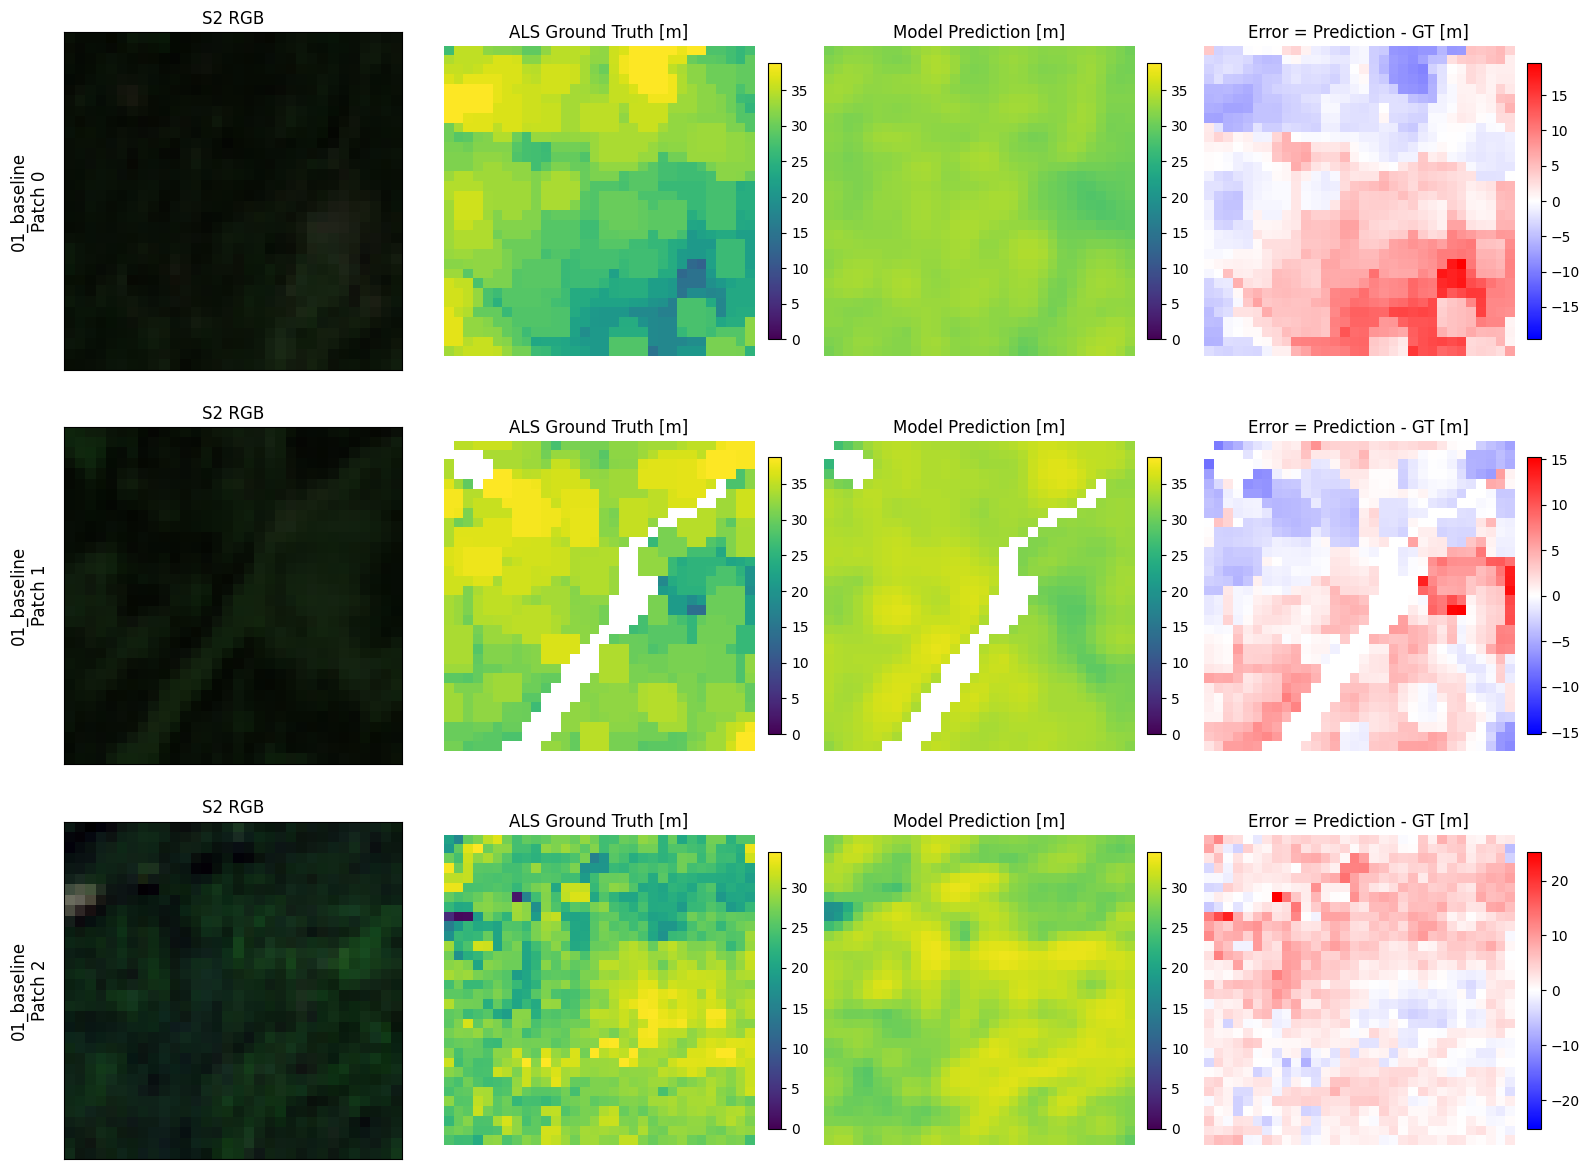

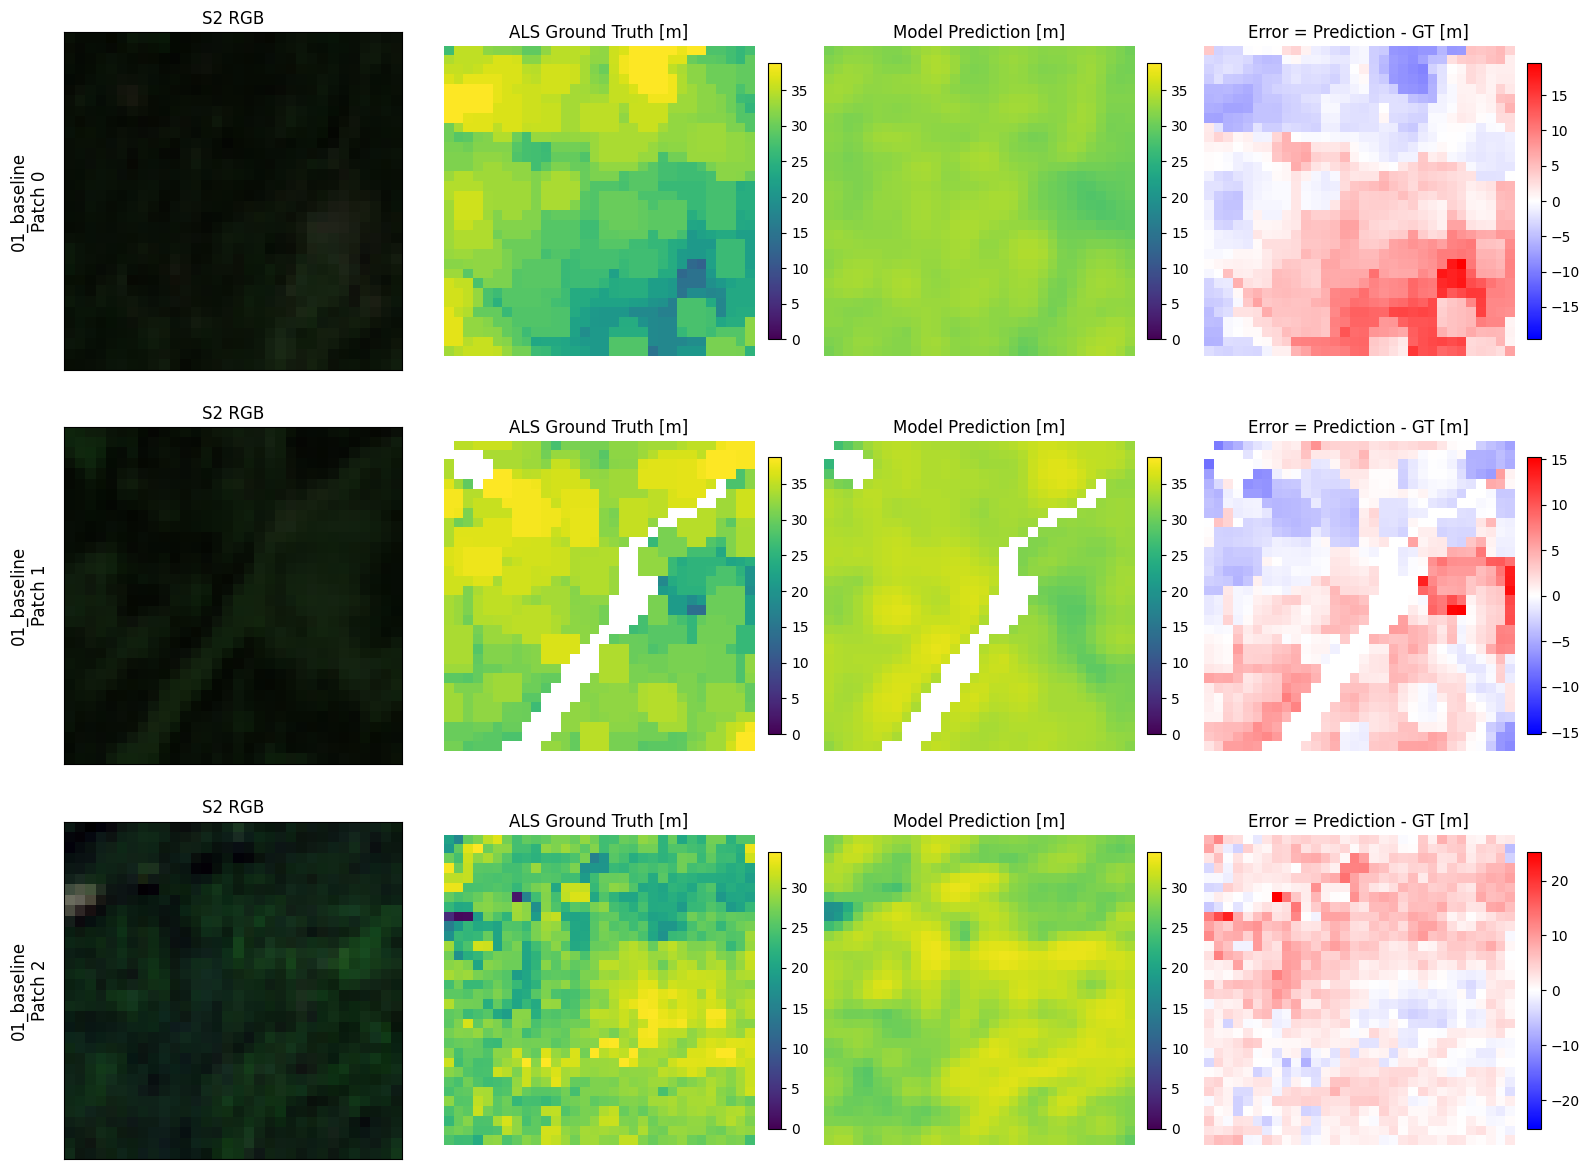

In [582]:
plot_first_n_patches(dfpatch=dfpatch, n=3)

In [595]:
def findgoodpatches(dfpatch, topk=1):
    """
    Return a filtered dfpatch with the top `topk` rows for each experiment.
    Top patches are selected by highest std in ground truth (targets_patch) and lowest mean error (abs(pred-gt)).
    """
    dfs = []
    blacklist = [13,131,141]
    for exp in dfpatch['experiment'].unique():
        sub = dfpatch[dfpatch['experiment'] == exp].copy()
        # Compute std of ground truth and mean error for each patch
        # Compute std of ground truth and mean error for each patch, using only valid (non-nan) pixels
        def valid_mask(x):
            return ~np.isnan(x)
        def nan_rate(x):
            return np.isnan(x).sum() / x.size
        sub['target_std'] = sub['targets_patch'].apply(lambda x: np.nanstd(x))
        sub['mean_error'] = sub.apply(lambda row: np.nanmean(np.abs(row['preds_patch'] - row['targets_patch'])), axis=1)
        sub['nan_rate'] = sub['targets_patch'].apply(nan_rate)
        # Only keep patches with less than 10% nan rate
        sub = sub[sub['nan_rate'] == 0.0]
        # Normalize both metrics to [0, 1] for equal weighting
        if len(sub) > 0:
            std_norm = (sub['target_std'] - sub['target_std'].min()) / (sub['target_std'].max() - sub['target_std'].min() + 1e-8)
            err_norm = (sub['mean_error'] - sub['mean_error'].min()) / (sub['mean_error'].max() - sub['mean_error'].min() + 1e-8)
            # Higher std is better, lower error is better
            sub['score'] = std_norm + (1 - err_norm)
            sub = sub.sort_values('score', ascending=False)
            # If PatchNum is not unique (e.g., due to concat from multiple runs), keep only the first occurrence
            if "PatchNum" in sub.columns:
                # Only keep rows whose PatchNum is not already in dfs
                existing_patchnums = set()
                for d in dfs:
                    if "PatchNum" in d.columns:
                        existing_patchnums.update(d["PatchNum"].tolist())
                sub = sub[~sub["PatchNum"].isin(existing_patchnums)]
                sub = sub[~sub["PatchNum"].isin(blacklist)]
                sub = sub.drop_duplicates(subset=["PatchNum"])
            sub = sub.head(topk)
        dfs.append(sub)
    return pd.concat(dfs, ignore_index=True)


In [596]:
dftop = findgoodpatches(dfpatch)

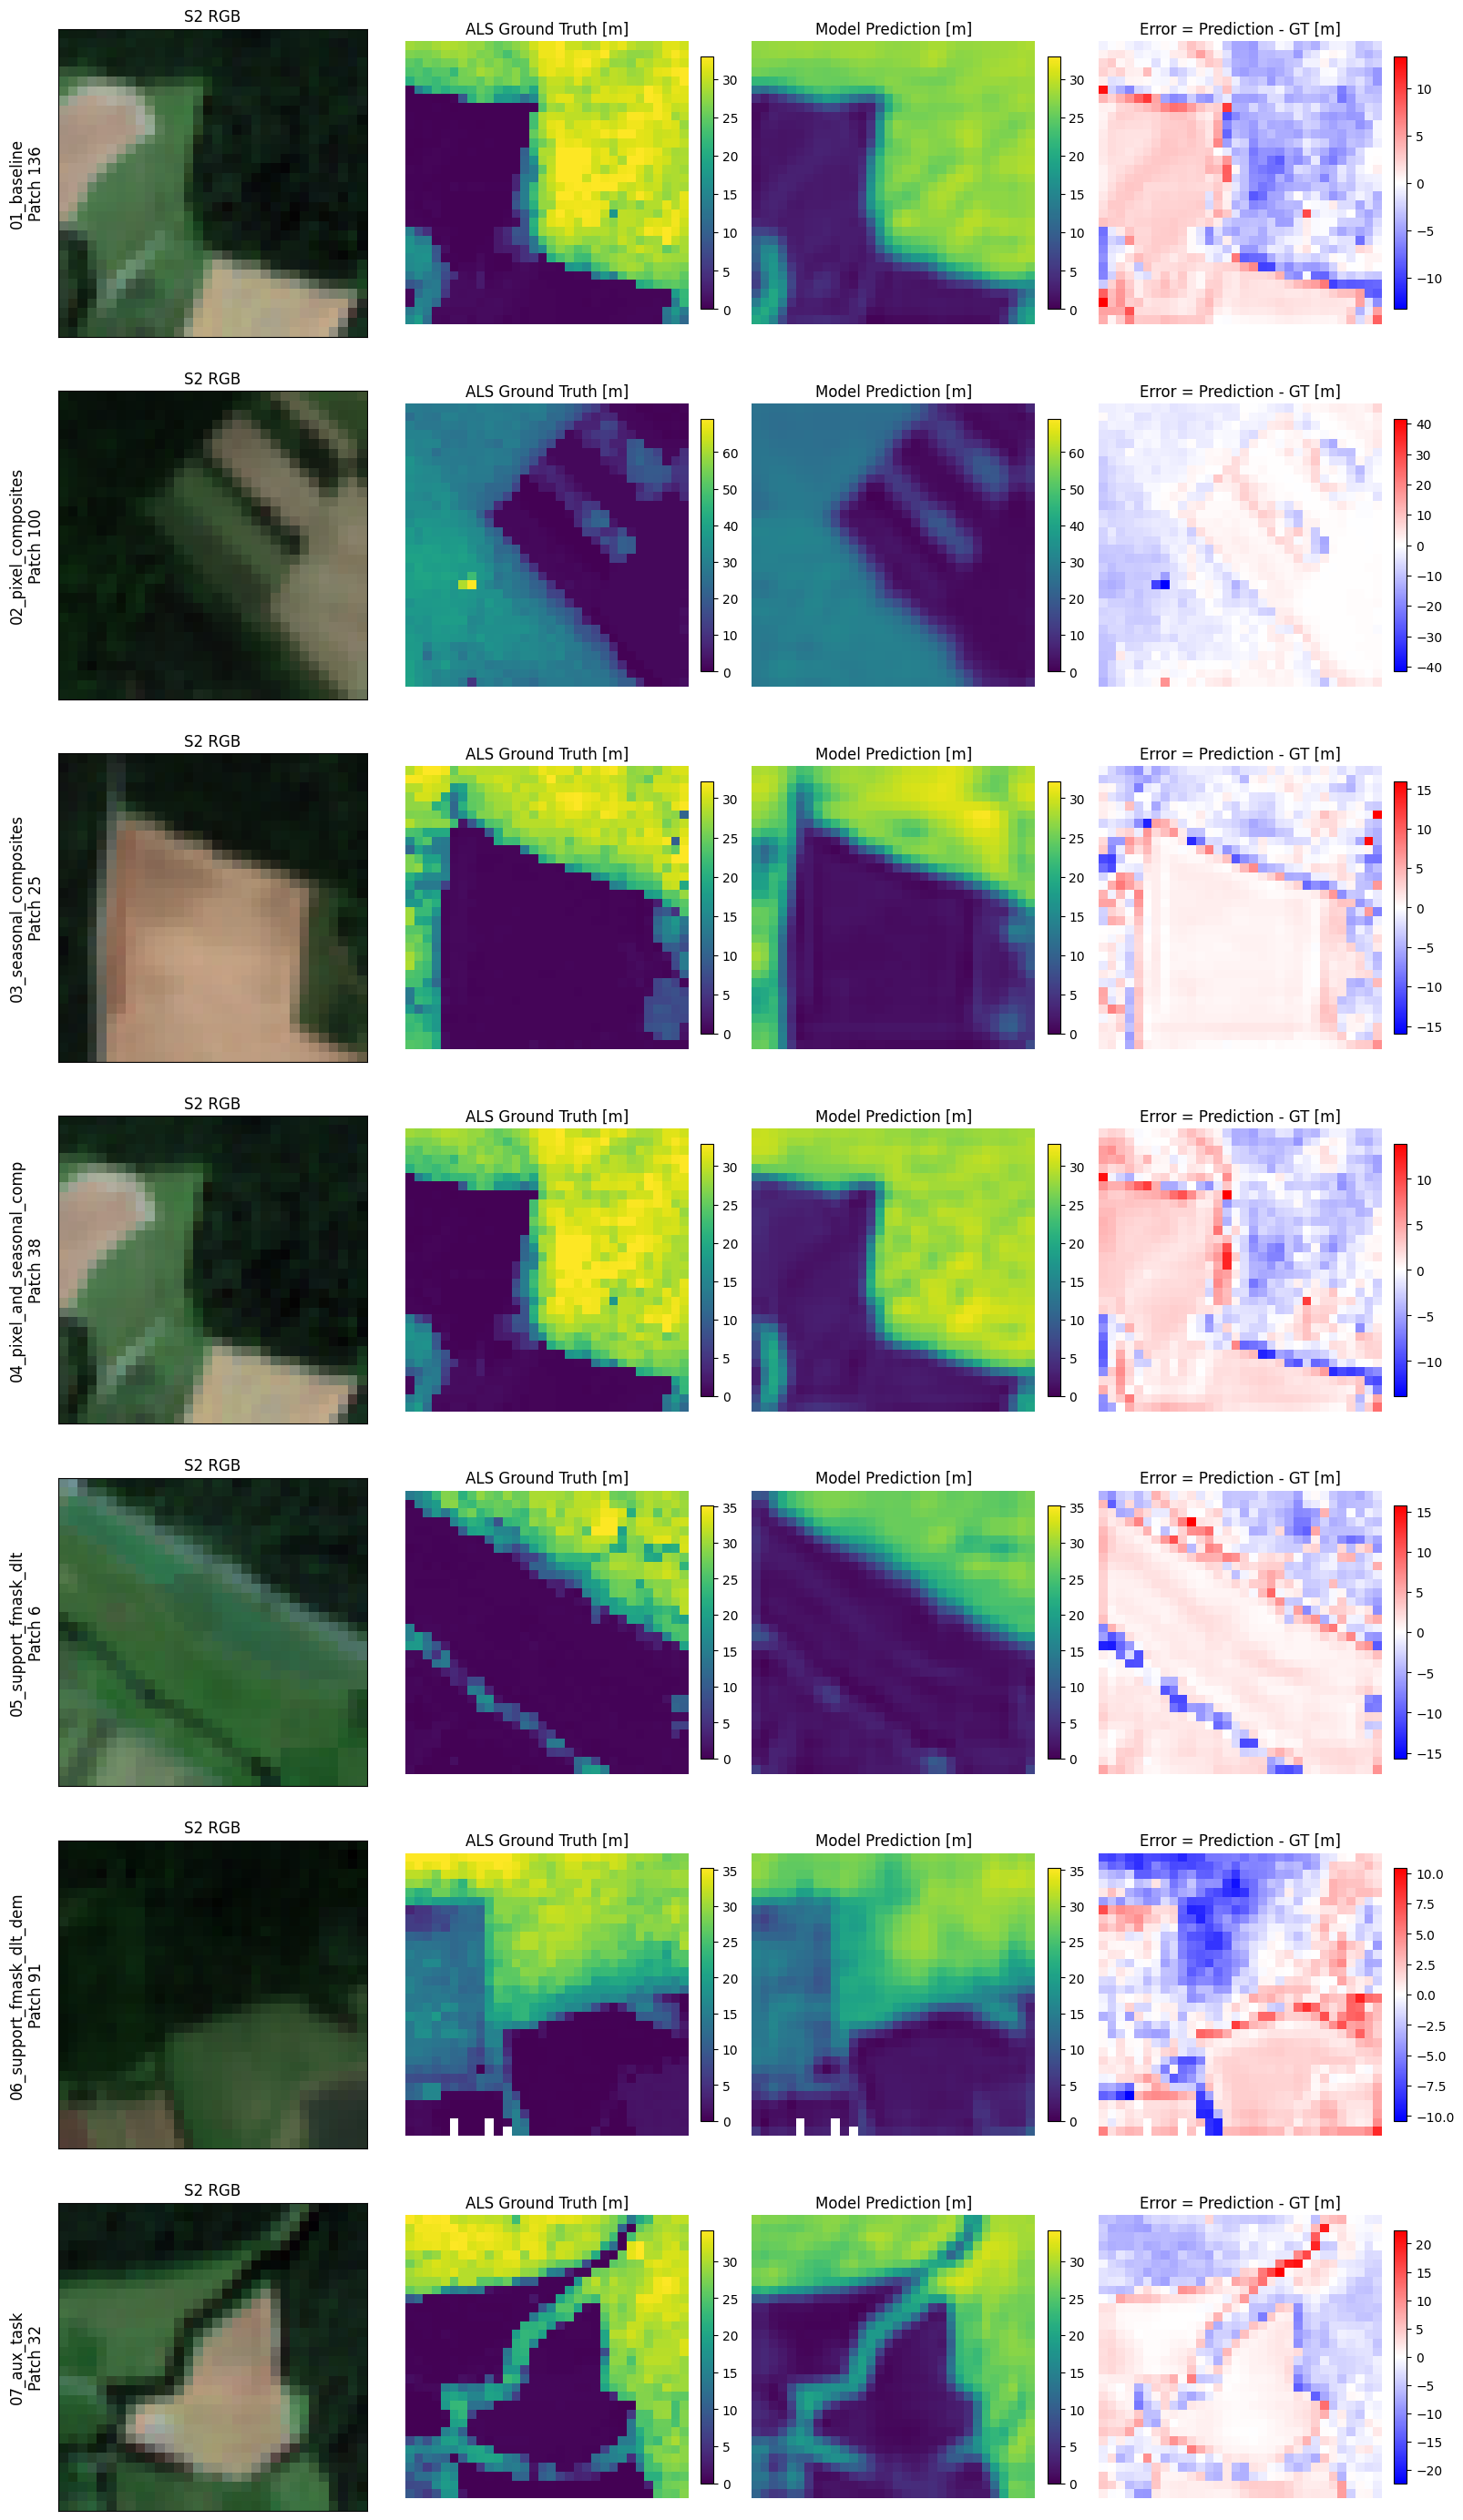

In [597]:
fig = plot_first_n_patches(dfpatch=dftop, n=7)
path = "../results/all_in/good_patches.png"
fig.savefig(path)

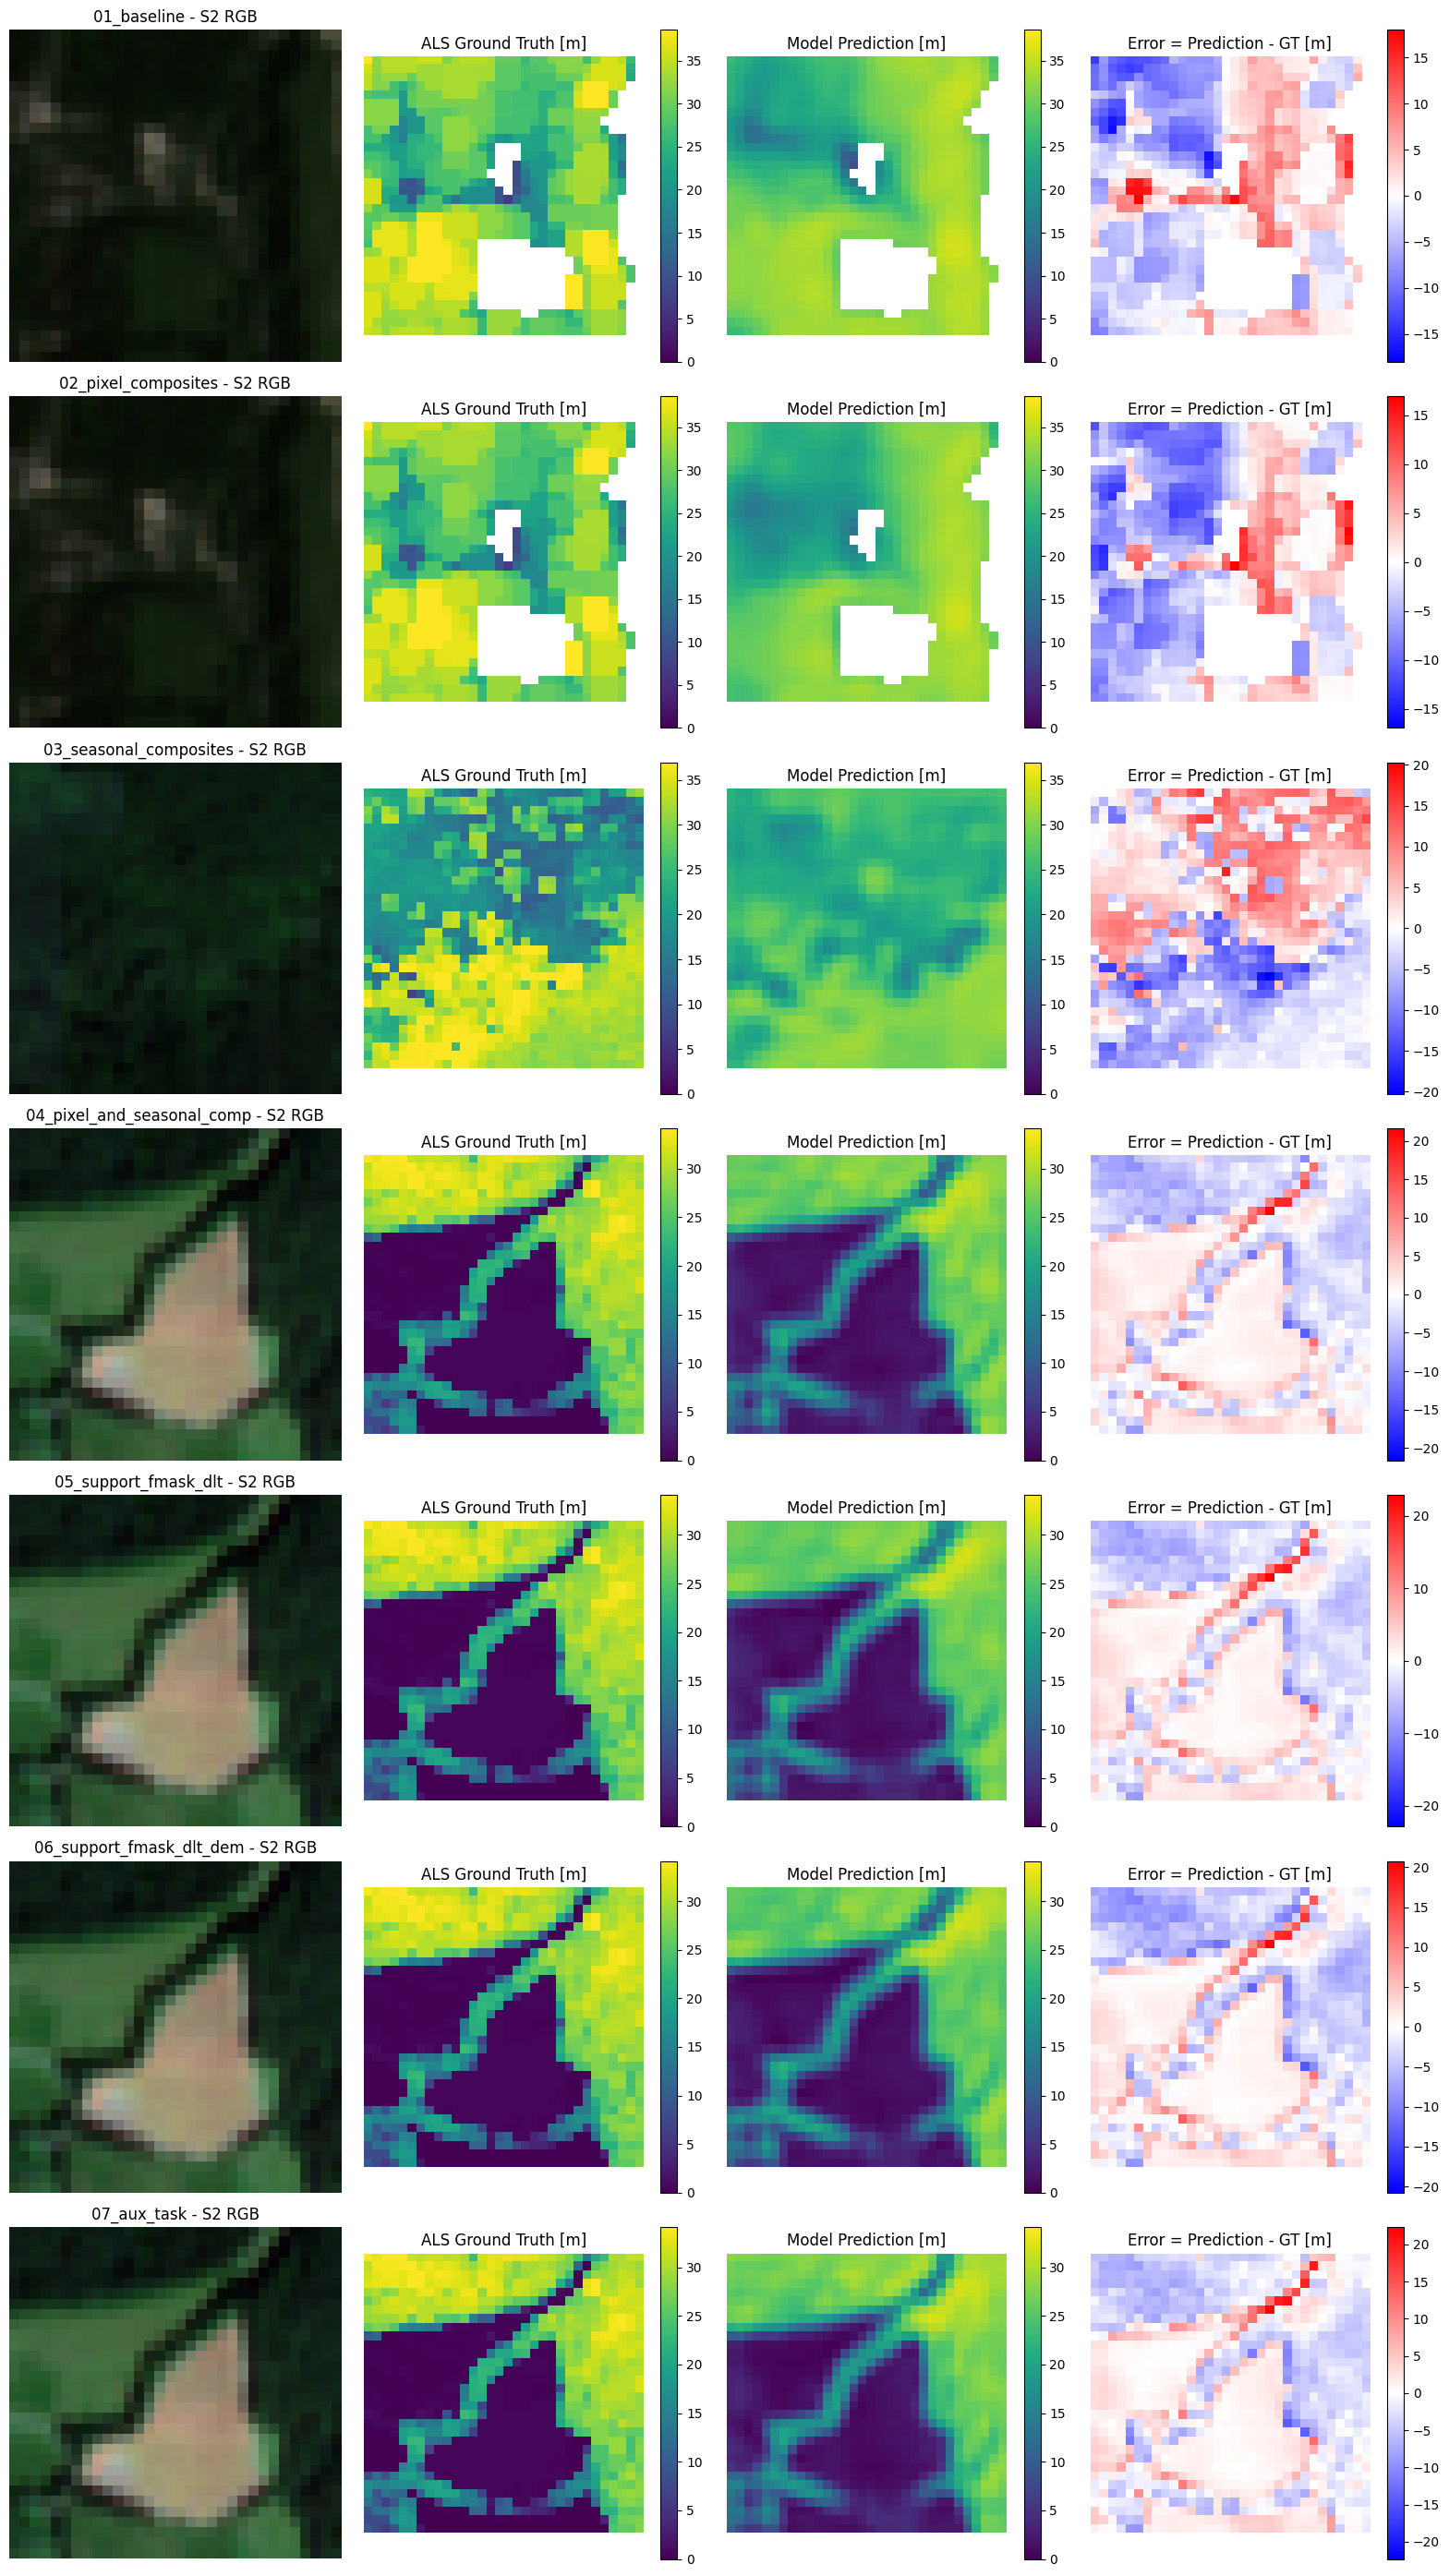

In [591]:
#run_id = 
patch_id = 32
run_id = "251028_PATCHSYNC_0"
plot_patch_across_experiments(dfpatch, run_id, patch_id)

## scribblsz

In [146]:
preds_val, targets_val, preds_test, targets_test, maskval, masktest = md.load_np_stacks('pixel_and_seasonal')

In [281]:
print(f"Shape of preds_val: {preds_val.shape}")
print(f"Shape of targets_val: {targets_val.shape}")
print(f"Shape of preds_test: {preds_test.shape}")
print(f"Shape of targets_test: {targets_test.shape}")
print(f"Shape of maskval: {maskval.shape}")
print(f"Shape of masktest: {masktest.shape}")

Shape of preds_val: (181, 3, 32, 32)
Shape of targets_val: (181, 3, 32, 32)
Shape of preds_test: (182, 3, 32, 32)
Shape of targets_test: (182, 3, 32, 32)
Shape of maskval: (181, 1, 32, 32)
Shape of masktest: (182, 1, 32, 32)


In [133]:
maskval[:,0,:,:] = maskval[:,0,:,:].astype(np.float32)

In [157]:
preds_test[:,0,:,:].min()

np.float32(22.851805)

In [80]:
cfg["strategy"]

'mid_level'

In [45]:
mu = sites['SITE2']['CHM_norm_params']['mu']
std = sites['SITE2']['CHM_norm_params']['std']


In [34]:
report["experiment_name"]

'baseline'

In [31]:
def save_results(model, val_loader, test_loader, normparams, logs, cfg):

    out_dir = os.path.join("../results/train", cfg['exp'])
    os.makedirs(out_dir, exist_ok=True)

    # Save model weights
    torch.save(model.state_dict(), os.path.join(out_dir, "model.pth"))

    # Save logs and cfg as JSON
    with open(os.path.join(out_dir, "logs.json"), "w") as f:
        json.dump(logs, f)
    with open(os.path.join(out_dir, "cfg.json"), "w") as f:
        json.dump(cfg, f)

    # Optionally, save predictions and targets for val/test sets
    preds_val, targets_val = get_predictions_and_targets(val_loader, model, normparams)
    preds_test, targets_test = get_predictions_and_targets(test_loader, model, normparams)

    # Zip predictions and targets for val/test sets and save as .npz files
    np.savez(os.path.join(out_dir, "val_preds_targets.npz"), preds_val=preds_val, targets_val=targets_val)
    np.savez(os.path.join(out_dir, "test_preds_targets.npz"), preds_test=preds_test, targets_test=targets_test)

    print("Results saved to:", out_dir)

def load_np_stacks(exp_dir):
    """
    Loads prediction and target numpy arrays from the experiment results folder.
    Returns preds_val, targets_val, preds_test, targets_test as numpy arrays.
    """
    out_dir = os.path.join("../results/train", exp_dir)
    val_npz = np.load(os.path.join(out_dir, "val_preds_targets.npz"))
    test_npz = np.load(os.path.join(out_dir, "test_preds_targets.npz"))
    preds_val = val_npz["preds_val"]
    targets_val = val_npz["targets_val"]
    preds_test = test_npz["preds_test"]
    targets_test = test_npz["targets_test"]
    return preds_val, targets_val, preds_test, targets_test

def load_results(exp_dir):
    """
    Loads model weights, logs, and cfg from the experiment results folder.
    """
    out_dir = os.path.join("../results/train", exp_dir)
    model_weights = torch.load(os.path.join(out_dir, "model.pth"))
    with open(os.path.join(out_dir, "logs.json"), "r") as f:
        logs = json.load(f)
    with open(os.path.join(out_dir, "cfg.json"), "r") as f:
        cfg = json.load(f)
    return model_weights, logs, cfg

def ziptheresults(exp_name, model_weights, logs, cfg, preds_val, targets_val, preds_test, targets_test):
    """
    Compile a new evaluation report for the given experiment.
    """
    report = {
        "experiment_name": exp_name,
        "model_weights": model_weights,
        "logs": logs,
        "config": cfg,
        "predictions": {
            "validation": preds_val,
            "test": preds_test
        },
        "targets": {
            "validation": targets_val,
            "test": targets_test
        }
    }
    return report